# Grocery Recommendation Project

1. Data Clustering on users  
2. Recommendation systems
  * Content-based filtering  
  * Collaborative filtering  
3. Market Basket analysis  
4. Website interface  

For this analysis I will be working as a Data Scientist for a grocery store that is looking to discover insights from sales data that could be used for targeted direct mail marketing (specific coupons mailed to customers), targeted email marketing ("An item you like has gone on sale!"), and online shopper recommendations to 'add to cart' based on similar items and also based on items other people who bought that item have purchased.  

If time permits, I may also perform a market basket analysis to forecast what products a customer is likely to purchase in their next order.

## Dataset information

This data was retrieved from Kaggle and was provided by Instacart for a market basket analysis competition in 2018.  

The data is divided into 6 files:

- **_Aisles.csv_**: 134 Unique aisle numbers and descriptions
- **_Departments.csv_**: 21 Unique department numbers and descriptions
- **_Products.csv_**: 49,688 Unique product ids, with description, aisle id, and department id
- **_Orders.csv_**: 3,421,083 Unique order id, with user id, order number, order_dow, order_hour_of_day, days_since_prior_order, and eval_set indicating if the order is in train, prior, or test
- **_Order_products_train.csv_**: Order id, product id, add to cart order, and reorder indicator
- **_Order_products_prior.csv_**: Order id, product id, add to cart order, and reorder indicator


Some ideas for exploration:

1. Look at ROI for each zip code, over the whole dataset, avg for each year, 3 year avg, 5 year avg, 10 year avg
2. Plot median sales price against ROI to get quadrants for comparison
3. Which zips have highest and lowest ROI?
4. Business case - choose highest ROI for small investors

## Data Preprocessing

### Import and basic info

**Output** - aisles, orders, products, departments, order_products_prior, order_products_train

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
from user_functions import *
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set default visualization parameters

CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'
color_list = [CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber, CB91_Purple, CB91_Violet]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)
sns.set_context("notebook", rc={"font.size":16, "axes.titlesize":20, "axes.labelsize":18})
sns.set(font='Franklin Gothic Book',
rc={'axes.axisbelow': False,
'axes.edgecolor': 'lightgrey',
# 'axes.edgecolor': 'white',
'axes.facecolor': 'None',
'axes.grid': False,
'axes.labelcolor': 'dimgrey',
# 'axes.labelcolor': 'white',
'axes.spines.right': False,
'axes.spines.top': False,
'axes.prop_cycle': plt.cycler(color=color_list),
'figure.facecolor': 'white',
'lines.solid_capstyle': 'round',
'patch.edgecolor': 'w',
'patch.force_edgecolor': True,
'text.color': 'dimgrey',
# 'text.color': 'white',    
'xtick.bottom': False,
'xtick.color': 'dimgrey',
# 'xtick.color': 'white',    
'xtick.direction': 'out',
'xtick.top': False,
'ytick.color': 'dimgrey',
# 'ytick.color': 'white',
'ytick.direction': 'out',
'ytick.left': False,
'ytick.right': False})
%matplotlib inline

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [3]:
aisles = pd.read_csv("Data/aisles.csv")
departments = pd.read_csv("Data/departments.csv")
order_products_prior = pd.read_csv("Data/order_products__prior.csv")
order_products_train = pd.read_csv("Data/order_products__train.csv")
orders = pd.read_csv("Data/orders.csv")
products = pd.read_csv("Data/products.csv")

In [4]:
aisles.head()

aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation

### Checking for Nan values

Data is very clean. Nan values in orders.days_since_prior_order, but they are valid.

In [5]:
aisles.isna().sum()

aisle_id    0
aisle       0
dtype: int64

In [6]:
departments.isna().sum()

department_id    0
department       0
dtype: int64

In [7]:
products.isna().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

In [8]:
orders.isna().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [9]:
orders.days_since_prior_order.value_counts()
# Nothing greater than 30 here so it must actually be '30+'

30.0    369323
7.0     320608
6.0     240013
4.0     221696
3.0     217005
5.0     214503
2.0     193206
8.0     181717
1.0     145247
9.0     118188
14.0    100230
10.0     95186
13.0     83214
11.0     80970
12.0     76146
0.0      67755
15.0     66579
16.0     46941
21.0     45470
17.0     39245
20.0     38527
18.0     35881
19.0     34384
22.0     32012
28.0     26777
23.0     23885
27.0     22013
24.0     20712
25.0     19234
29.0     19191
26.0     19016
Name: days_since_prior_order, dtype: int64

In [10]:
orders.head()
# order_id is a unique key for the order
# order_number is specific to a user
# seems like for any user, order 1 will have a Nan in days_since_prior_order since it is their first order

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0

In [11]:
order_products_train.isna().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [12]:
order_products_prior.isna().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

### Analyze 'Products'
  
49688 unique products 

In [13]:
products.head()

product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id  
0             19  
1             13  
2              7  
3              1  
4             13

In [14]:
print(len(products))
print(products.aisle_id.nunique())
print(products.department_id.nunique())

49688
134
21


In [15]:
# How many products in each department and aisle?
# I guess these would be better/more informative with aisle and dept names
products_aisles = pd.merge(products, aisles, on = 'aisle_id', how = 'left')
products_desc = pd.merge(products_aisles, departments, on = 'department_id', how = 'left')
products_desc.head()

product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id                       aisle department  
0             19               cookies cakes     snacks  
1             13           spices seasonings     pantry  
2              7                         tea  beverages  
3              1                frozen meals     frozen  
4             13  marinades meat preparation     pantry

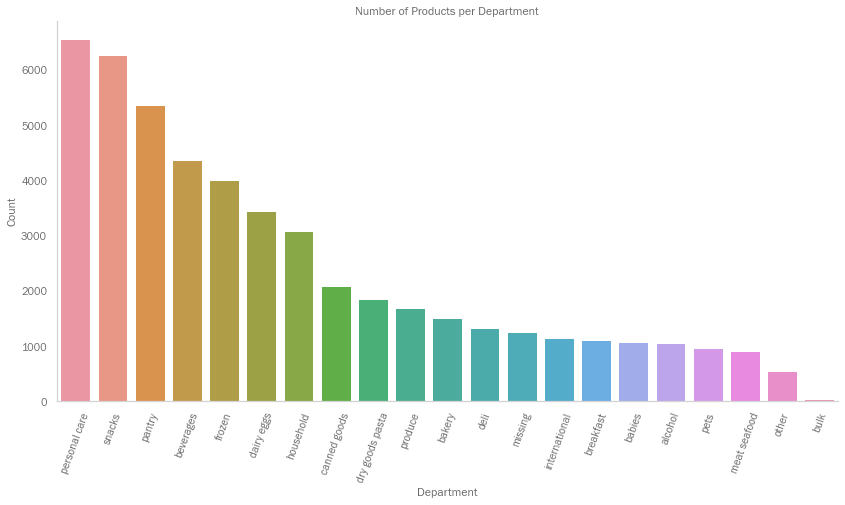

In [16]:
plt.figure(figsize = (14,7))
sns.countplot(x='department', data= products_desc, order = products_desc.department.value_counts().index)
plt.title('Number of Products per Department')
plt.xticks(rotation=70)
plt.ylabel('Count')
plt.xlabel('Department')
plt.savefig('Images/products_by_department.png');

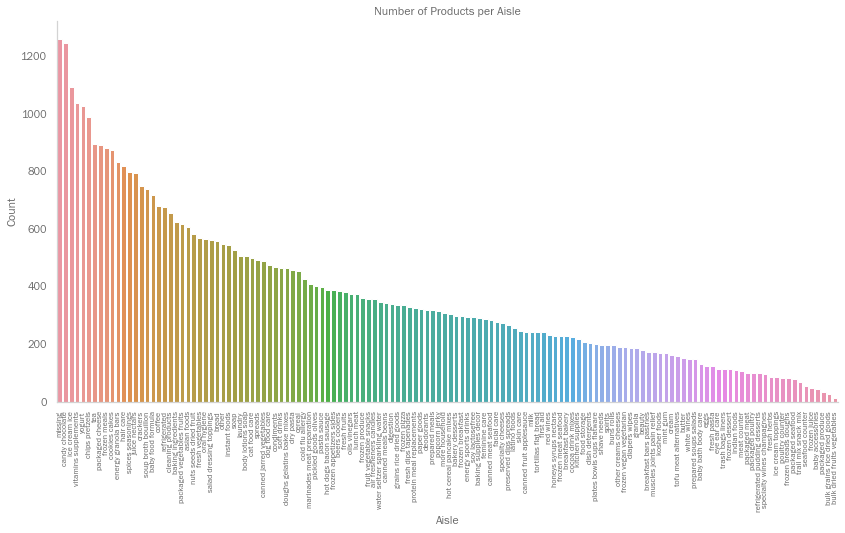

In [17]:
plt.figure(figsize = (14,7))
sns.countplot(x='aisle', data= products_desc, order = products_desc.aisle.value_counts().index)
plt.title('Number of Products per Aisle')
plt.xticks(rotation=90, fontsize = 8)
plt.ylabel('Count')
plt.xlabel('Aisle')
plt.savefig('Images/products_by_aisle.png');
# Uh oh, 'missing' is our most popular aisle
# And I see there is a 'missing' value for department above as well

In [18]:
products_desc[products_desc['aisle']=='missing']
# It appears that 1258 products have 'missing' aisle 100 and department 21

product_id                                       product_name  \
37             38                    Ultra Antibacterial Dish Liquid   
71             72                          Organic Honeycrisp Apples   
109           110                             Uncured Turkey Bologna   
296           297  Write Bros Ball Point Pens, Cap-Pen, Medium (1...   
416           417         Classics Baby Binks Easter Chocolate Bunny   
...           ...                                                ...   
49552       49553                                 Organic Plain Skyr   
49574       49575                     Chocolate Vanilla Malt Custard   
49640       49641                                      8\" Pecan Pie   
49663       49664                     Lemon Cayenne Drinking Vinegar   
49668       49669                                   K Cup Dark Blend   

       aisle_id  department_id    aisle department  
37          100             21  missing    missing  
71          100             21  missing    missing  
109         100             21  missing    missing  
296         100             21  missing    missing  
416         100             21  missing    missing  
...         ...            ...      ...        ...  
49552       100             21  missing    missing  
49574       100             21  missing    missing  
49640       100             21  missing    missing  
49663       100             21  missing    missing  
49668       100             21  missing    missing  

[1258 rows x 6 columns]

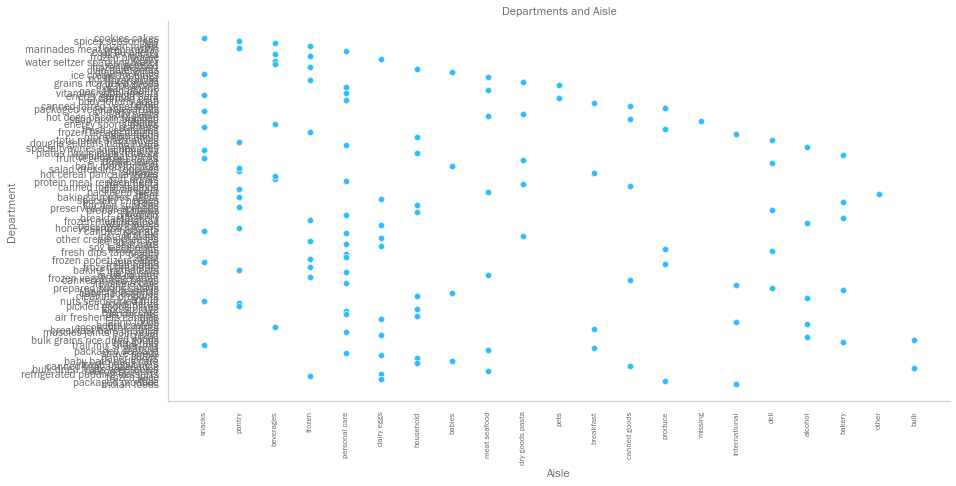

In [19]:
plt.figure(figsize = (14,7))
sns.scatterplot(y='aisle', x='department', data= products_desc)
plt.title('Departments and Aisle')
plt.xticks(rotation=90, fontsize = 8)
plt.ylabel('Department')
plt.xlabel('Aisle')
plt.savefig('Images/depts_by_aisle.png');

In [20]:
# Just confirming the one to many relationship between department and aisle
products_desc[products_desc['department']=='snacks']

product_id                                   product_name  aisle_id  \
0               1                     Chocolate Sandwich Cookies        61   
15             16                  Mint Chocolate Flavored Syrup       103   
24             25        Salted Caramel Lean Protein & Fiber Bar         3   
31             32                  Nacho Cheese White Bean Chips       107   
40             41    Organic Sourdough Einkorn Crackers Rosemary        78   
...           ...                                            ...       ...   
49661       49662                   Bacon Cheddar Pretzel Pieces       107   
49664       49665  Super Dark Coconut Ash & Banana Chocolate Bar        45   
49665       49666                  Ginger Snaps Snacking Cookies        61   
49670       49671                           Milk Chocolate Drops        45   
49678       49679                        Famous Chocolate Wafers        61   

       department_id                aisle department  
0                 19        cookies cakes     snacks  
15                19   ice cream toppings     snacks  
24                19  energy granola bars     snacks  
31                19       chips pretzels     snacks  
40                19             crackers     snacks  
...              ...                  ...        ...  
49661             19       chips pretzels     snacks  
49664             19      candy chocolate     snacks  
49665             19        cookies cakes     snacks  
49670             19      candy chocolate     snacks  
49678             19        cookies cakes     snacks  

[6264 rows x 6 columns]

In [21]:
# An aisle only belongs to one department
products_desc[products_desc['aisle_id']==45]

product_id                                   product_name  aisle_id  \
123           124                        Sun Cups Dark Chocolate        45   
135           136                                         Simple        45   
183           184                    Kisses Milk Chocolate Candy        45   
206           207                               Minis Candy Bars        45   
226           227                    Triple Chocolate Snack Size        45   
...           ...                                            ...       ...   
49503       49504   Dark Chocolate Peanut Butter Cups Miniatures        45   
49600       49601                        Pomegranate Gummy Bears        45   
49619       49620                          Milk Chocolate Mini's        45   
49664       49665  Super Dark Coconut Ash & Banana Chocolate Bar        45   
49670       49671                           Milk Chocolate Drops        45   

       department_id            aisle department  
123               19  candy chocolate     snacks  
135               19  candy chocolate     snacks  
183               19  candy chocolate     snacks  
206               19  candy chocolate     snacks  
226               19  candy chocolate     snacks  
...              ...              ...        ...  
49503             19  candy chocolate     snacks  
49600             19  candy chocolate     snacks  
49619             19  candy chocolate     snacks  
49664             19  candy chocolate     snacks  
49670             19  candy chocolate     snacks  

[1246 rows x 6 columns]

### Analyze Orders

In [22]:
print(len(orders))
print(orders.order_id.min())
print(orders.order_id.max())

3421083
1
3421083


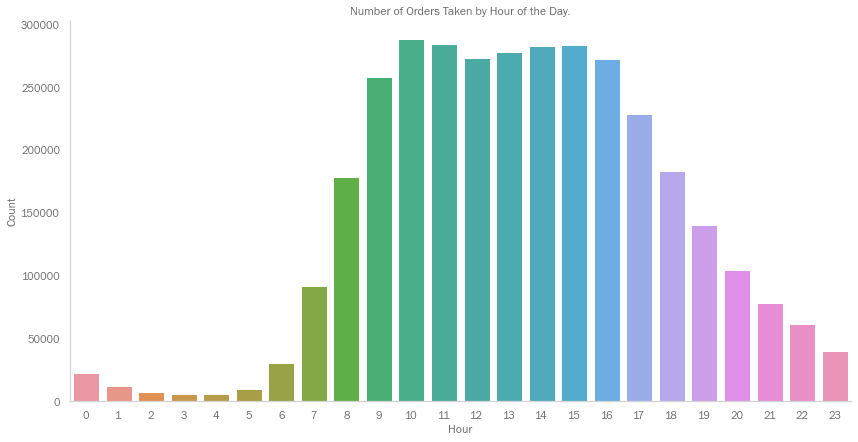

In [23]:
plt.figure(figsize = (14,7))
sns.countplot(x='order_hour_of_day', data= orders)
plt.title('Number of Orders Taken by Hour of the Day.')
plt.ylabel('Count')
plt.xlabel('Hour')
plt.savefig('Images/orders_by_hour.png');

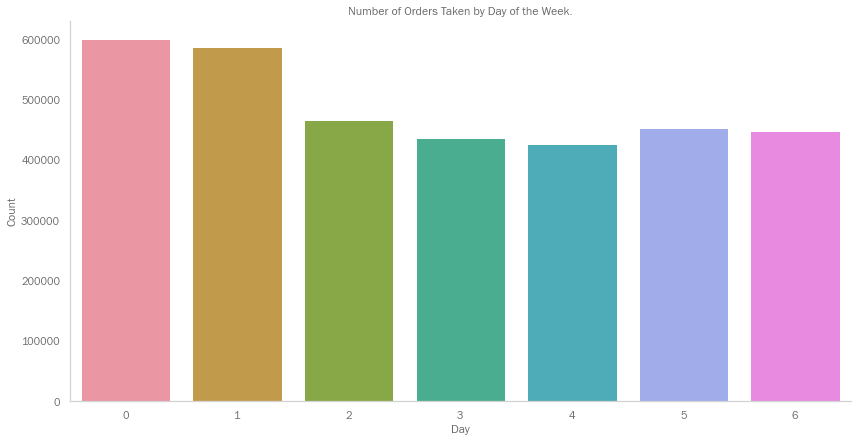

In [24]:
plt.figure(figsize = (14,7))
sns.countplot(x='order_dow', data= orders)
plt.title('Number of Orders Taken by Day of the Week.')
plt.ylabel('Count')
plt.xlabel('Day')
plt.savefig('Images/orders_by_dow.png');

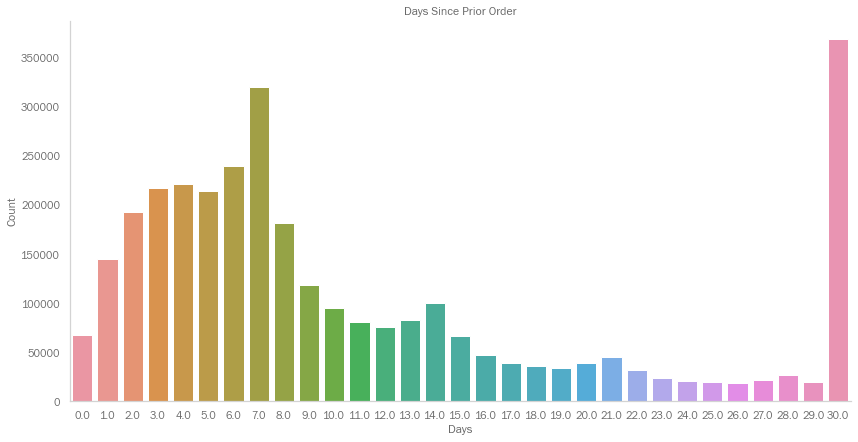

In [25]:
plt.figure(figsize = (14,7))
sns.countplot(x='days_since_prior_order', data= orders)
plt.title('Days Since Prior Order')
plt.ylabel('Count')
plt.xlabel('Days')
plt.savefig('Images/days_since_order.png');

# Spikes at 7, 14, 21, and 28 indicate people who reorder weekly, or every 2 or three weeks but on the same day
# Does 0.0 days mean someone ordered twice in the same day?
# Surprising how many people order more than once a week
# 30 does seem to indicate 30 or more days since last order

In [26]:
orders.head(15)
# Appears to be sorted by user_id and then order_number
# Most recent order_number per user_id is in the train(or test) set, others in prior
# First order per user has NaN in days_since

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0    2539329        1    prior             1          2                  8   
1    2398795        1    prior             2          3                  7   
2     473747        1    prior             3          3                 12   
3    2254736        1    prior             4          4                  7   
4     431534        1    prior             5          4                 15   
5    3367565        1    prior             6          2                  7   
6     550135        1    prior             7          1                  9   
7    3108588        1    prior             8          1                 14   
8    2295261        1    prior             9          1                 16   
9    2550362        1    prior            10          4                  8   
10   1187899        1    train            11          4                  8   
11   2168274        2    prior             1          2                 11   
12   1501582        2    prior             2          5                 10   
13   1901567        2    prior             3          1                 10   
14    738281        2    prior             4          2                 10   

    days_since_prior_order  
0                      NaN  
1                     15.0  
2                     21.0  
3                     29.0  
4                     28.0  
5                     19.0  
6                     20.0  
7                     14.0  
8                      0.0  
9                     30.0  
10                    14.0  
11                     NaN  
12                    10.0  
13                     3.0  
14                     8.0

In [27]:
orders.sort_values('order_id') # Just checking that it has all the order_ids starting at 1

order_id  user_id eval_set  order_number  order_dow  \
1868044         1   112108    train             4          4   
3355525         2   202279    prior             3          5   
3417191         3   205970    prior            16          5   
2958007         4   178520    prior            36          1   
2593373         5   156122    prior            42          6   
...           ...      ...      ...           ...        ...   
1809968   3421079   108687    prior             6          1   
877324    3421080    52726    prior             2          1   
1949724   3421081   117076    prior             1          3   
2903252   3421082   175185    prior            23          2   
419472    3421083    25247    prior            24          2   

         order_hour_of_day  days_since_prior_order  
1868044                 10                     9.0  
3355525                  9                     8.0  
3417191                 17                    12.0  
2958007                  9                     7.0  
2593373                 16                     9.0  
...                    ...                     ...  
1809968                 13                     0.0  
877324                  11                     2.0  
1949724                 11                     NaN  
2903252                 18                     4.0  
419472                   6                    21.0  

[3421083 rows x 7 columns]

In [28]:
orders_test = orders[orders['eval_set']=='test'] # 75000 orders in our test set
# So basically for these test orders, I don't have the answers.  I don't know what products were ordered.
orders_test

order_id  user_id eval_set  order_number  order_dow  \
38        2774568        3     test            13          5   
44         329954        4     test             6          3   
53        1528013        6     test             4          3   
96        1376945       11     test             8          6   
102       1356845       12     test             6          1   
...           ...      ...      ...           ...        ...   
3420918   2728930   206202     test            23          2   
3420929    350108   206204     test             5          4   
3421001   1043943   206206     test            68          0   
3421018   2821651   206207     test            17          2   
3421068    803273   206208     test            50          5   

         order_hour_of_day  days_since_prior_order  
38                      15                    11.0  
44                      12                    30.0  
53                      16                    22.0  
96                      11                     8.0  
102                     20                    30.0  
...                    ...                     ...  
3420918                 17                     6.0  
3420929                 14                    14.0  
3421001                 20                     0.0  
3421018                 13                    14.0  
3421068                 11                     4.0  

[75000 rows x 7 columns]

In [29]:
orders[orders['user_id']==3] # But I have all of this user's order/products in prior

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
26   1374495        3    prior             1          1                 14   
27    444309        3    prior             2          3                 19   
28   3002854        3    prior             3          3                 16   
29   2037211        3    prior             4          2                 18   
30   2710558        3    prior             5          0                 17   
31   1972919        3    prior             6          0                 16   
32   1839752        3    prior             7          0                 15   
33   3225766        3    prior             8          0                 17   
34   3160850        3    prior             9          0                 16   
35    676467        3    prior            10          3                 16   
36    521107        3    prior            11          0                 18   
37   1402502        3    prior            12          1                 15   
38   2774568        3     test            13          5                 15   

    days_since_prior_order  
26                     NaN  
27                     9.0  
28                    21.0  
29                    20.0  
30                    12.0  
31                     7.0  
32                     7.0  
33                     7.0  
34                     7.0  
35                    17.0  
36                    11.0  
37                    15.0  
38                    11.0

### Analyze Order_products_train and _prior

In [30]:
order_products_train.head()

order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1
2         1       10246                  3          0
3         1       49683                  4          0
4         1       43633                  5          1

In [31]:
print(len(order_products_train)) # Has 1,384,617 order/products
print(order_products_train.order_id.min()) # starts with order number 1
print(order_products_train.order_id.max())
print(order_products_train.order_id.nunique()) # Has 131,209 unique orders

1384617
1
3421070
131209


In [32]:
order_products_prior.head()

order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0

In [33]:
print(len(order_products_prior)) # Has 32,434,489 order/products
print(order_products_prior.order_id.min()) # starts with order number 2
print(order_products_prior.order_id.max())
print(order_products_prior.order_id.nunique()) # Has 3,214,874 unique orders

32434489
2
3421083
3214874


In [34]:
order_products_prior[order_products_prior.order_id == 2]

order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0
5         2       17794                  6          1
6         2       40141                  7          1
7         2        1819                  8          1
8         2       43668                  9          0

In [35]:
orders[orders.order_id == 2]

order_id  user_id eval_set  order_number  order_dow  \
3355525         2   202279    prior             3          5   

         order_hour_of_day  days_since_prior_order  
3355525                  9                     8.0

In [36]:
orders[orders.user_id == 202279]
# This user's third order was order number 2.  Need to be sure not to think order_id is chronological.

order_id  user_id eval_set  order_number  order_dow  \
3355523   2894949   202279    prior             1          5   
3355524   1500071   202279    prior             2          4   
3355525         2   202279    prior             3          5   
3355526   3058248   202279    prior             4          3   
3355527   2808715   202279    prior             5          5   
3355528    132412   202279    prior             6          5   
3355529   2382766   202279    prior             7          1   
3355530    104690   202279    prior             8          6   
3355531   1050357   202279    train             9          1   

         order_hour_of_day  days_since_prior_order  
3355523                  9                     NaN  
3355524                 13                    20.0  
3355525                  9                     8.0  
3355526                 14                    30.0  
3355527                 13                     9.0  
3355528                  9                    30.0  
3355529                 14                    24.0  
3355530                 10                    30.0  
3355531                 14                    30.0

In [37]:
order_products_train[order_products_train.order_id == 1050357]

order_id  product_id  add_to_cart_order  reordered
429686   1050357       33120                  1          1
429687   1050357        1003                  2          1
429688   1050357       21543                  3          1
429689   1050357       20995                  4          1
429690   1050357       46064                  5          0
429691   1050357       20168                  6          0
429692   1050357       42824                  7          1
429693   1050357        4461                  8          1
429694   1050357       45002                  9          1
429695   1050357        8693                 10          0

In [38]:
# So what do I know about this user...

# They have ordered 9 times.
len(orders[orders.user_id == 202279])

9

In [39]:
# They usually order on day 5 (presumably Friday)
orders[orders.user_id == 202279].order_dow.mode()

0    5
dtype: int64

In [40]:
# They average 22.6 days between orders
orders[orders.user_id == 202279].days_since_prior_order.mean()

22.625

In [41]:
# They order around 11:30 am.
orders[orders.user_id == 202279].order_hour_of_day.mean()

11.666666666666666

In [42]:
# These are their order numbers
list(orders[orders.user_id == 202279]['order_id'].values)

[2894949, 1500071, 2, 3058248, 2808715, 132412, 2382766, 104690, 1050357]

In [43]:
# But what products have they ordered... merging tables will help here
order_products_prior[order_products_prior['order_id'].isin(list(orders[orders.user_id == 202279]['order_id'].values))]

order_id  product_id  add_to_cart_order  reordered
0                2       33120                  1          1
1                2       28985                  2          1
2                2        9327                  3          0
3                2       45918                  4          1
4                2       30035                  5          0
...            ...         ...                ...        ...
28997578   3058248       27531                  4          0
28997579   3058248        2944                  5          0
28997580   3058248       38226                  6          0
28997581   3058248       35106                  7          0
28997582   3058248       12545                  8          0

[90 rows x 4 columns]

## Merge order_products together

Output: merged_order_products, order_products_desc

In [44]:
print(len(order_products_train))
print(len(order_products_prior))

1384617
32434489


In [45]:
# The dataframe of all order products should be the length of these two together
len(order_products_train)+len(order_products_prior)

33819106

In [46]:
# These two dataframes shouldn't have any overlap.  I need an outer join to merge them together.
merged_order_products = pd.merge(order_products_train, order_products_prior, how = 'outer')
merged_order_products.head()

order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1
2         1       10246                  3          0
3         1       49683                  4          0
4         1       43633                  5          1

In [47]:
len(merged_order_products)

33819106

In [48]:
# This has an entry for each ordered product.  If we combine it with aisle and department we can see which products
# are ordered the most.
order_products_desc = pd.merge(merged_order_products, products_desc, on = 'product_id')
order_products_desc.head()

order_id  product_id  add_to_cart_order  reordered      product_name  \
0         1       49302                  1          1  Bulgarian Yogurt   
1    816049       49302                  7          1  Bulgarian Yogurt   
2   1242203       49302                  1          1  Bulgarian Yogurt   
3   1383349       49302                 11          1  Bulgarian Yogurt   
4   1787378       49302                  8          0  Bulgarian Yogurt   

   aisle_id  department_id   aisle  department  
0       120             16  yogurt  dairy eggs  
1       120             16  yogurt  dairy eggs  
2       120             16  yogurt  dairy eggs  
3       120             16  yogurt  dairy eggs  
4       120             16  yogurt  dairy eggs

In [49]:
# Very cool.  People really like their bananas.
order_products_desc['product_name'].value_counts()

Banana                                                       491291
Bag of Organic Bananas                                       394930
Organic Strawberries                                         275577
Organic Baby Spinach                                         251705
Organic Hass Avocado                                         220877
                                                              ...  
Piquillo & Jalapeno Bruschetta                                    1
Lowfat Cherry Lime Supernova Kefir Cultured Milk Smoothie         1
Bottle & Nipple Brush Set                                         1
Sweetart Jelly Beans                                              1
Tropic Thunder  Coconut & Cream                                   1
Name: product_name, Length: 49685, dtype: int64

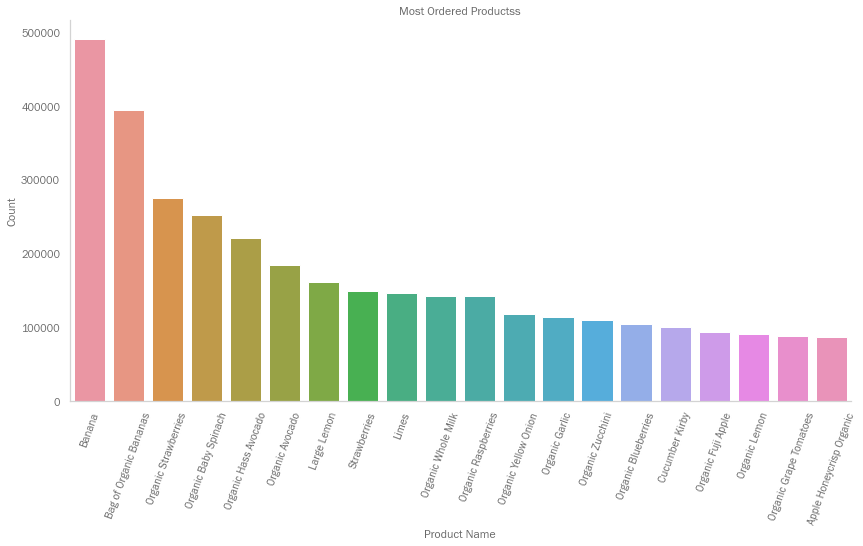

In [50]:
plt.figure(figsize = (14,7))
sns.countplot(x='product_name', data= order_products_desc, 
              order = order_products_desc.product_name.value_counts().index[:20])
plt.title('Most Ordered Productss')
plt.xticks(rotation=70)
plt.ylabel('Count')
plt.xlabel('Product Name')
plt.savefig('Images/ordered_products_by_name.png');

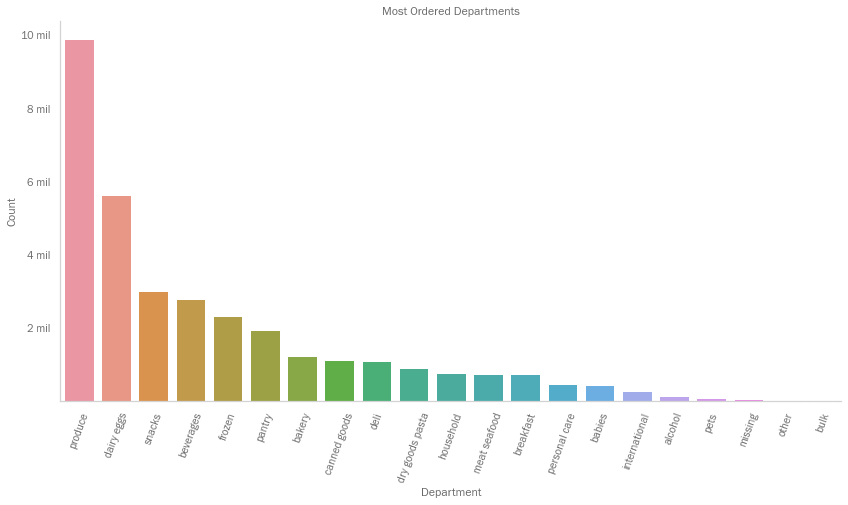

In [51]:
plt.figure(figsize = (14,7))
sns.countplot(x='department', data= order_products_desc, order = order_products_desc.department.value_counts().index)
plt.title('Most Ordered Departments')
plt.xticks(rotation=70)
plt.yticks([2000000,4000000,6000000,8000000,10000000],['2 mil','4 mil','6 mil','8 mil','10 mil'])
plt.ylabel('Count')
plt.xlabel('Department')
plt.savefig('Images/ordered_products_by_department.png');

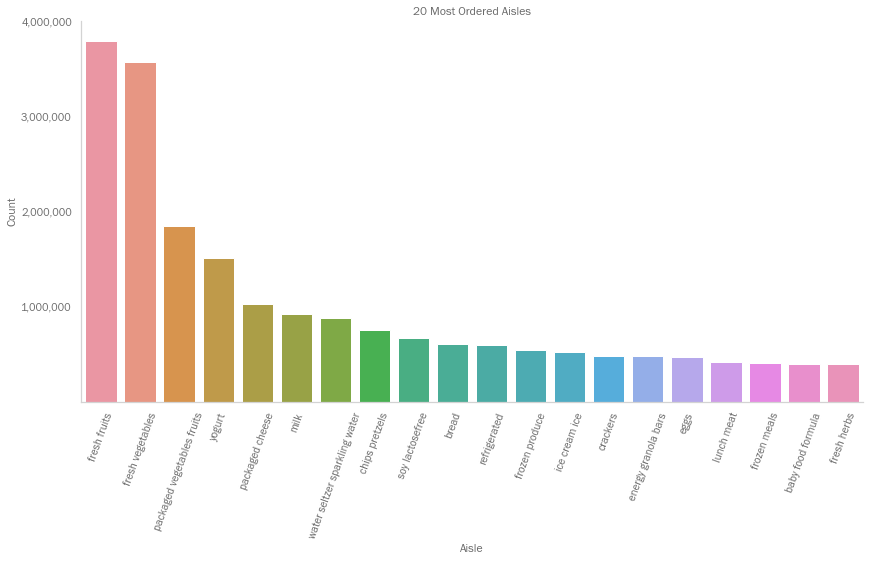

In [52]:
plt.figure(figsize = (14,7))
sns.countplot(x='aisle', data= order_products_desc, order = order_products_desc.aisle.value_counts().index[:20])
plt.title('20 Most Ordered Aisles')
plt.xticks(rotation=70)
plt.yticks([1000000,2000000,3000000,4000000],['1,000,000','2,000,000','3,000,000','4,000,000'])
plt.ylabel('Count')
plt.xlabel('Aisle')
plt.savefig('Images/ordered_products_by_aisle.png');

## Analyze user orders

Output: merged_orders

In [53]:
# Now merge the orders with the ordered prodcuts, combining on order_id
# This is a lot of info. We will trim some out before modeling.
merged_orders = pd.merge(orders, order_products_desc, on = 'order_id')
merged_orders.head() # Because the products showing are from the 1st order for this user, they all have Nan in days_since
# Because pd.merge defaults to an inner join, the test orders are not in this dataframe because they had no products.

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2539329        1    prior             1          2                  8   
2   2539329        1    prior             1          2                  8   
3   2539329        1    prior             1          2                  8   
4   2539329        1    prior             1          2                  8   

   days_since_prior_order  product_id  add_to_cart_order  reordered  \
0                     NaN         196                  1          0   
1                     NaN       26088                  4          0   
2                     NaN       14084                  2          0   
3                     NaN       26405                  5          0   
4                     NaN       12427                  3          0   

                              product_name  aisle_id  department_id  \
0                                     Soda        77              7   
1               Aged White Cheddar Popcorn        23             19   
2  Organic Unsweetened Vanilla Almond Milk        91             16   
3         XL Pick-A-Size Paper Towel Rolls        54             17   
4                      Original Beef Jerky        23             19   

             aisle  department  
0      soft drinks   beverages  
1    popcorn jerky      snacks  
2  soy lactosefree  dairy eggs  
3      paper goods   household  
4    popcorn jerky      snacks

In [54]:
len(merged_orders)

33819106

In [55]:
merged_orders[merged_orders['user_id']==3] # We see 12 orders, 88 products, no test order

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
296   1374495        3    prior             1          1                 14   
297   1374495        3    prior             1          1                 14   
298   1374495        3    prior             1          1                 14   
299   1374495        3    prior             1          1                 14   
300   1374495        3    prior             1          1                 14   
..        ...      ...      ...           ...        ...                ...   
379   1402502        3    prior            12          1                 15   
380   1402502        3    prior            12          1                 15   
381   1402502        3    prior            12          1                 15   
382   1402502        3    prior            12          1                 15   
383   1402502        3    prior            12          1                 15   

     days_since_prior_order  product_id  add_to_cart_order  reordered  \
296                     NaN       39190                  5          0   
297                     NaN       16797                  4          0   
298                     NaN        9387                  1          0   
299                     NaN       21903                  7          0   
300                     NaN       39922                  8          0   
..                      ...         ...                ...        ...   
379                    15.0       18599                  2          1   
380                    15.0       21903                  4          1   
381                    15.0       47766                  5          1   
382                    15.0       24810                  6          1   
383                    15.0       23650                  3          1   

                                product_name  aisle_id  department_id  \
296          Vanilla Unsweetened Almond Milk        91             16   
297                             Strawberries        24              4   
298                      Granny Smith Apples        24              4   
299                     Organic Baby Spinach       123              4   
300                            Celery Sticks       123              4   
..                                       ...       ...            ...   
379                          Garlic Couscous         4              9   
380                     Organic Baby Spinach       123              4   
381                          Organic Avocado        24              4   
382  Organic Lightly Salted Brown Rice Cakes        78             19   
383                        Electrolyte Water       115              7   

                             aisle       department  
296                soy lactosefree       dairy eggs  
297                   fresh fruits          produce  
298                   fresh fruits          produce  
299     packaged vegetables fruits          produce  
300     packaged vegetables fruits          produce  
..                             ...              ...  
379                  instant foods  dry goods pasta  
380     packaged vegetables fruits          produce  
381                   fresh fruits          produce  
382                       crackers           snacks  
383  water seltzer sparkling water        beverages  

[88 rows x 15 columns]

In [56]:
orders[orders['user_id']==3]

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
26   1374495        3    prior             1          1                 14   
27    444309        3    prior             2          3                 19   
28   3002854        3    prior             3          3                 16   
29   2037211        3    prior             4          2                 18   
30   2710558        3    prior             5          0                 17   
31   1972919        3    prior             6          0                 16   
32   1839752        3    prior             7          0                 15   
33   3225766        3    prior             8          0                 17   
34   3160850        3    prior             9          0                 16   
35    676467        3    prior            10          3                 16   
36    521107        3    prior            11          0                 18   
37   1402502        3    prior            12          1                 15   
38   2774568        3     test            13          5                 15   

    days_since_prior_order  
26                     NaN  
27                     9.0  
28                    21.0  
29                    20.0  
30                    12.0  
31                     7.0  
32                     7.0  
33                     7.0  
34                     7.0  
35                    17.0  
36                    11.0  
37                    15.0  
38                    11.0

In [57]:
# Creating the test set of orders
test = orders[orders['eval_set']=='test']
test.head()

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
38    2774568        3     test            13          5                 15   
44     329954        4     test             6          3                 12   
53    1528013        6     test             4          3                 16   
96    1376945       11     test             8          6                 11   
102   1356845       12     test             6          1                 20   

     days_since_prior_order  
38                     11.0  
44                     30.0  
53                     22.0  
96                      8.0  
102                    30.0

In [58]:
# Now I can see everything a particular user has ordered, and how often
merged_orders[merged_orders['user_id']==3]['product_name'].value_counts()

Vanilla Unsweetened Almond Milk                    10
Organic Avocado                                     9
Organic Baby Spinach                                8
Unsweetened Chocolate Almond Breeze Almond Milk     5
Granny Smith Apples                                 5
Garlic Couscous                                     4
Organic Peeled Whole Baby Carrots                   4
All Natural No Stir Creamy Almond Butter            3
Organic Whole String Cheese                         3
Crackers, Crispy, Cheddar                           3
Organic Lightly Salted Brown Rice Cakes             3
Strawberries                                        3
Green Beans                                         2
Chocolate Ice Cream                                 2
Birthday Cake Light Ice Cream                       2
Original Rotisserie Chicken                         2
Brussels Sprouts                                    2
Electrolyte Water                                   2
Wheat Gluten Free Waffles   

In [59]:
# Here is every time this user ordered Organic Avocado
merged_orders[(merged_orders['user_id']==3) & (merged_orders['product_name']=='Organic Avocado')]

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
301   1374495        3    prior             1          1                 14   
318   3002854        3    prior             3          3                 16   
331   2710558        3    prior             5          0                 17   
341   1972919        3    prior             6          0                 16   
359   3225766        3    prior             8          0                 17   
365   3160850        3    prior             9          0                 16   
369    676467        3    prior            10          3                 16   
376    521107        3    prior            11          0                 18   
381   1402502        3    prior            12          1                 15   

     days_since_prior_order  product_id  add_to_cart_order  reordered  \
301                     NaN       47766                  6          0   
318                    21.0       47766                  2          1   
331                    12.0       47766                  4          1   
341                     7.0       47766                  4          1   
359                     7.0       47766                  6          1   
365                     7.0       47766                  2          1   
369                    17.0       47766                  3          1   
376                    11.0       47766                  2          1   
381                    15.0       47766                  5          1   

        product_name  aisle_id  department_id         aisle department  
301  Organic Avocado        24              4  fresh fruits    produce  
318  Organic Avocado        24              4  fresh fruits    produce  
331  Organic Avocado        24              4  fresh fruits    produce  
341  Organic Avocado        24              4  fresh fruits    produce  
359  Organic Avocado        24              4  fresh fruits    produce  
365  Organic Avocado        24              4  fresh fruits    produce  
369  Organic Avocado        24              4  fresh fruits    produce  
376  Organic Avocado        24              4  fresh fruits    produce  
381  Organic Avocado        24              4  fresh fruits    produce

## Clustering

In [93]:
# Now I want to experiment with clustering the 'similar' users together
# But what data do I need for each user?  Some kind of summary statistics?
# I guess I need each product to be a column, with the number of times it was ordered?

In [60]:
merged_orders.head()

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2539329        1    prior             1          2                  8   
2   2539329        1    prior             1          2                  8   
3   2539329        1    prior             1          2                  8   
4   2539329        1    prior             1          2                  8   

   days_since_prior_order  product_id  add_to_cart_order  reordered  \
0                     NaN         196                  1          0   
1                     NaN       26088                  4          0   
2                     NaN       14084                  2          0   
3                     NaN       26405                  5          0   
4                     NaN       12427                  3          0   

                              product_name  aisle_id  department_id  \
0                                     Soda        77              7   
1               Aged White Cheddar Popcorn        23             19   
2  Organic Unsweetened Vanilla Almond Milk        91             16   
3         XL Pick-A-Size Paper Towel Rolls        54             17   
4                      Original Beef Jerky        23             19   

             aisle  department  
0      soft drinks   beverages  
1    popcorn jerky      snacks  
2  soy lactosefree  dairy eggs  
3      paper goods   household  
4    popcorn jerky      snacks

In [62]:
# What don't I need for my user dataframe?
user_info = merged_orders.iloc[:,:8]

In [63]:
user_info.head()

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2539329        1    prior             1          2                  8   
2   2539329        1    prior             1          2                  8   
3   2539329        1    prior             1          2                  8   
4   2539329        1    prior             1          2                  8   

   days_since_prior_order  product_id  
0                     NaN         196  
1                     NaN       26088  
2                     NaN       14084  
3                     NaN       26405  
4                     NaN       12427

In [67]:
user_data = pd.get_dummies(user_info, prefix='product', prefix_sep='_', dummy_na=False, columns=['product_id'], 
               sparse=True, drop_first=False, dtype=None)

In [68]:
user_data
# Group By User_id
# I need nunique or order_id or max of order_number
# Drop eval_set
# Mode of order_dow, mean of order_hour_of_day, mean of days_since
# Count of each product

order_id  user_id eval_set  order_number  order_dow  \
0          2539329        1    prior             1          2   
1          2539329        1    prior             1          2   
2          2539329        1    prior             1          2   
3          2539329        1    prior             1          2   
4          2539329        1    prior             1          2   
...            ...      ...      ...           ...        ...   
33819101    272231   206209    train            14          6   
33819102    272231   206209    train            14          6   
33819103    272231   206209    train            14          6   
33819104    272231   206209    train            14          6   
33819105    272231   206209    train            14          6   

          order_hour_of_day  days_since_prior_order  product_1  product_2  \
0                         8                     NaN          0          0   
1                         8                     NaN          0          0   
2                         8                     NaN          0          0   
3                         8                     NaN          0          0   
4                         8                     NaN          0          0   
...                     ...                     ...        ...        ...   
33819101                 14                    30.0          0          0   
33819102                 14                    30.0          0          0   
33819103                 14                    30.0          0          0   
33819104                 14                    30.0          0          0   
33819105                 14                    30.0          0          0   

          product_3  ...  product_49679  product_49680  product_49681  \
0                 0  ...              0              0              0   
1                 0  ...              0              0              0   
2                 0  ...              0              0              0   
3                 0  ...              0              0              0   
4                 0  ...              0              0              0   
...             ...  ...            ...            ...            ...   
33819101          0  ...              0              0              0   
33819102          0  ...              0              0              0   
33819103          0  ...              0              0              0   
33819104          0  ...              0              0              0   
33819105          0  ...              0              0              0   

          product_49682  product_49683  product_49684  product_49685  \
0                     0              0              0              0   
1                     0              0              0              0   
2                     0              0              0              0   
3                     0              0              0              0   
4                     0              0              0              0   
...                 ...            ...            ...            ...   
33819101              0              0              0              0   
33819102              0              0              0              0   
33819103              0              0              0              0   
33819104              0              0              0              0   
33819105              0              0              0              0   

          product_49686  product_49687  product_49688  
0                     0              0              0  
1                     0              0              0  
2                     0              0              0  
3                     0              0              0  
4                     0              0              0  
...                 ...            ...            ...  
33819101              0              0              0  
33819102              0              0              0  
33819103              0              0              0  
33

In [70]:
user_data.groupby('user_id').mean()

KeyboardInterrupt: 

In [101]:
user_info = merged_orders.groupby(by='user_id')

In [103]:
# I want to count of order_id, max of order_number, mode of order_dow...
# Drop eval_set, product descriptions
user_info.count()

order_id  eval_set  order_number  order_dow  order_hour_of_day  \
user_id                                                                   
1              70        70            70         70                 70   
2             226       226           226        226                226   
3              88        88            88         88                 88   
4              18        18            18         18                 18   
5              46        46            46         46                 46   
...           ...       ...           ...        ...                ...   
206205         51        51            51         51                 51   
206206        285       285           285        285                285   
206207        223       223           223        223                223   
206208        677       677           677        677                677   
206209        137       137           137        137                137   

         days_since_prior_order  product_id  add_to_cart_order  reordered  \
user_id                                                                     
1                            65          70                 70         70   
2                           213         226                226        226   
3                            78          88                 88         88   
4                            14          18                 18         18   
5                            35          46                 46         46   
...                         ...         ...                ...        ...   
206205                       34          51                 51         51   
206206                      281         285                285        285   
206207                      199         223                223        223   
206208                      665         677                677        677   
206209                      124         137                137        137   

         product_name  aisle_id  department_id  aisle  department  
user_id                                                            
1                  70        70             70     70          70  
2                 226       226            226    226         226  
3                  88        88             88     88          88  
4                  18        18             18     18          18  
5                  46        46             46     46          46  
...               ...       ...            ...    ...         ...  
206205             51        51             51     51          51  
206206            285       285            285    285         285  
206207            223       223            223    223         223  
206208            677       677            677    677         677  
206209            137       137            137    137         137  

[206209 rows x 14 columns]

In [111]:
merged_orders[merged_orders['user_id']==1]['order_number'].max()

11

In [113]:
merged_orders[merged_orders['user_id']==1]['order_id'].nunique()

11

In [122]:
# I think I need to feature engineer each column I want and drop the others

merged_orders['num_orders'] = merged_orders['user_id'].map([lambda x: merged_orders[merged_orders['user_id']==x]['order_id'].nunique()])

TypeError: 'list' object is not callable

In [ ]:
merged_orders.head()

## Convert to date types

In [48]:
# Function provided in starter notebook
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[:], format='%Y-%m')

In [49]:
# These are my date columns only.  Running them through the function.
zillow_top_date_df = zillow_top.iloc[:,7:-3]
zillow_top_date_df.columns = list(get_datetimes(zillow_top_date_df))
zillow_top_date_df

1996-04-01  1996-05-01  1996-06-01  1996-07-01  1996-08-01  1996-09-01  \
466      27600.0     27500.0     27500.0     27400.0     27400.0     27300.0   
1754         NaN         NaN         NaN         NaN         NaN         NaN   
2199     47700.0     48000.0     48300.0     48400.0     48500.0     48500.0   
3853         NaN         NaN         NaN         NaN         NaN         NaN   
4293     41300.0     41200.0     41200.0     41100.0     41000.0     40800.0   
5682     54800.0     55000.0     55200.0     55400.0     55700.0     55900.0   

      1996-10-01  1996-11-01  1996-12-01  1997-01-01  ...  2017-07-01  \
466      27300.0     27200.0     27200.0     27300.0  ...       39000   
1754         NaN         NaN         NaN         NaN  ...       66700   
2199     48500.0     48400.0     48400.0     48400.0  ...       82300   
3853         NaN         NaN         NaN         NaN  ...       67600   
4293     40700.0     40500.0     40500.0     40500.0  ...       47300   
5682     56200.0     56400.0     56700.0     57000.0  ...       82300   

      2017-08-01  2017-09-01  2017-10-01  2017-11-01  2017-12-01  2018-01-01  \
466        39100       39100       39600       40600       41600       42600   
1754       66700       66900       67000       66600       67400       69200   
2199       83300       84300       85500       86700       87900       89000   
3853       68600       68800       69400       71800       75700       78800   
4293       47900       49700       51600       54200       55700       55700   
5682       84500       85800       87400       89200       90500       91700   

      2018-02-01  2018-03-01  2018-04-01  
466        44000       45700       46600  
1754       70600       71800       73500  
2199       90400       91900       92600  
3853       81300       84500       88100  
4293       55900       57800       59800  
5682       93500       95000       95600  

[6 rows x 265 columns]

In [50]:
# Now put the df back together, 7 info columns, 3 feature columns of ROI calculation, then date columns.
zillow_top_date = pd.concat([zillow_top.iloc[:, :7], zillow_top.iloc[:, -3:], zillow_top_date_df], axis=1)
zillow_top_date

RegionID RegionName           City State          Metro    CountyName  \
466     65801      19134   Philadelphia    PA   Philadelphia  Philadelphia   
1754    78022      46203   Indianapolis    IN   Indianapolis        Marion   
2199    71793      32114  Daytona Beach    FL  Daytona Beach       Volusia   
3853    76575      43206       Columbus    OH       Columbus      Franklin   
4293    87104      66104    Kansas City    KS    Kansas City     Wyandotte   
5682    74373      37411    Chattanooga    TN    Chattanooga      Hamilton   

      SizeRank  4_yr_ROI  recent_1_yr_ROI  avg_one_yr_ROI  ...  \
466        467  0.834646         0.259459        0.268561  ...   
1754      1755  1.047354         0.137771        0.231818  ...   
2199      2200  0.909278         0.169192        0.210909  ...   
3853      3854  0.984234         0.409600        0.225806  ...   
4293      4294  0.986711         0.300000        0.226380  ...   
5682      5683  0.623090         0.283221        0.219015  ...   

      2017-07-01 00:00:00  2017-08-01 00:00:00  2017-09-01 00:00:00  \
466                 39000                39100                39100   
1754                66700                66700                66900   
2199                82300                83300                84300   
3853                67600                68600                68800   
4293                47300                47900                49700   
5682                82300                84500                85800   

      2017-10-01 00:00:00  2017-11-01 00:00:00  2017-12-01 00:00:00  \
466                 39600                40600                41600   
1754                67000                66600                67400   
2199                85500                86700                87900   
3853                69400                71800                75700   
4293                51600                54200                55700   
5682                87400                89200                90500   

      2018-01-01 00:00:00  2018-02-01 00:00:00  2018-03-01 00:00:00  \
466                 42600                44000                45700   
1754                69200                70600                71800   
2199                89000                90400                91900   
3853                78800                81300                84500   
4293                55700                55900                57800   
5682                91700                93500                95000   

      2018-04-01 00:00:00  
466                 46600  
1754                73500  
2199                92600  
3853                88100  
4293                59800  
5682                95600  

[6 rows x 275 columns]

In [51]:
zillow_top_date.isna().sum().sum()

324

## Reshape from wide to long format

In [52]:
# Create a separate data frame for each of the 6 top zip codes.
Philly = zillow_top_date[zillow_top_date['RegionName']=='19134']
Indy = zillow_top_date[zillow_top_date['RegionName']=='46203']
Daytona = zillow_top_date[zillow_top_date['RegionName']=='32114']
Columbus = zillow_top_date[zillow_top_date['RegionName']=='43206']
KC = zillow_top_date[zillow_top_date['RegionName']=='66104']
Chattanooga = zillow_top_date[zillow_top_date['RegionName']=='37411']

In [53]:
# Columbus and Indy have missing data.  I don't want to back fill multiple years worth of data.
# I'd rather slice off what I have and backfill only occasional missing data
Indy.isna().sum().sum()

111

In [54]:
Indy.columns[Indy.isnull().any()] # Indy begins recording data at 2005-07-01

Index([1996-04-01 00:00:00, 1996-05-01 00:00:00, 1996-06-01 00:00:00,
       1996-07-01 00:00:00, 1996-08-01 00:00:00, 1996-09-01 00:00:00,
       1996-10-01 00:00:00, 1996-11-01 00:00:00, 1996-12-01 00:00:00,
       1997-01-01 00:00:00,
       ...
       2004-09-01 00:00:00, 2004-10-01 00:00:00, 2004-11-01 00:00:00,
       2004-12-01 00:00:00, 2005-01-01 00:00:00, 2005-02-01 00:00:00,
       2005-03-01 00:00:00, 2005-04-01 00:00:00, 2005-05-01 00:00:00,
       2005-06-01 00:00:00],
      dtype='object', length=111)

In [55]:
Columbus.columns[Columbus.isnull().any()] # Columbus begins recording data at 2014-01-01

Index([1996-04-01 00:00:00, 1996-05-01 00:00:00, 1996-06-01 00:00:00,
       1996-07-01 00:00:00, 1996-08-01 00:00:00, 1996-09-01 00:00:00,
       1996-10-01 00:00:00, 1996-11-01 00:00:00, 1996-12-01 00:00:00,
       1997-01-01 00:00:00,
       ...
       2013-03-01 00:00:00, 2013-04-01 00:00:00, 2013-05-01 00:00:00,
       2013-06-01 00:00:00, 2013-07-01 00:00:00, 2013-08-01 00:00:00,
       2013-09-01 00:00:00, 2013-10-01 00:00:00, 2013-11-01 00:00:00,
       2013-12-01 00:00:00],
      dtype='object', length=213)

In [56]:
Indy_notnull = Indy[Indy.columns.drop(Indy.columns[Indy.isnull().any()])]
Columbus_notnull = Columbus[Columbus.columns.drop(Columbus.columns[Columbus.isnull().any()])]

In [57]:
Indy_notnull

RegionID RegionName          City State         Metro CountyName  \
1754    78022      46203  Indianapolis    IN  Indianapolis     Marion   

      SizeRank  4_yr_ROI  recent_1_yr_ROI  avg_one_yr_ROI  ...  \
1754      1755  1.047354         0.137771        0.231818  ...   

      2017-07-01 00:00:00  2017-08-01 00:00:00  2017-09-01 00:00:00  \
1754                66700                66700                66900   

      2017-10-01 00:00:00  2017-11-01 00:00:00  2017-12-01 00:00:00  \
1754                67000                66600                67400   

      2018-01-01 00:00:00  2018-02-01 00:00:00  2018-03-01 00:00:00  \
1754                69200                70600                71800   

      2018-04-01 00:00:00  
1754                73500  

[1 rows x 164 columns]

In [58]:
def melt_data(list_of_dfs): # changed to take in a list of dataframes for scalability
    """Convert list of time series dataframes into melted format"""
    return_list = []
    for df in list_of_dfs:
        melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 'CountyName',
                                     'SizeRank', '4_yr_ROI', 'recent_1_yr_ROI','avg_one_yr_ROI'], var_name='time')
        melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
#         melted = melted.dropna(subset=['value'])
        melted = melted.bfill() # I'm adding this to try backfill instead of dropna
        return_list.append(melted.groupby('time').aggregate({'value':'mean'}))
    return return_list

In [59]:
zips_to_melt = [Philly, Indy_notnull, Daytona, Columbus_notnull, KC, Chattanooga]
Philly_melted, Indy_melted, Daytona_melted, Columbus_melted, KC_melted, Chattanooga_melted = melt_data(zips_to_melt)

Indy_melted

value
time               
2005-07-01  73600.0
2005-08-01  74700.0
2005-09-01  75700.0
2005-10-01  76600.0
2005-11-01  77200.0
...             ...
2017-12-01  67400.0
2018-01-01  69200.0
2018-02-01  70600.0
2018-03-01  71800.0
2018-04-01  73500.0

[154 rows x 1 columns]

## Visualize time series plots

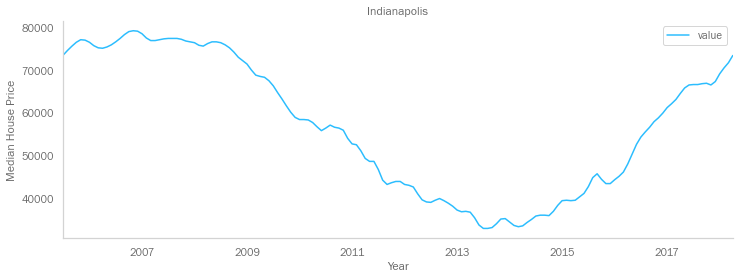

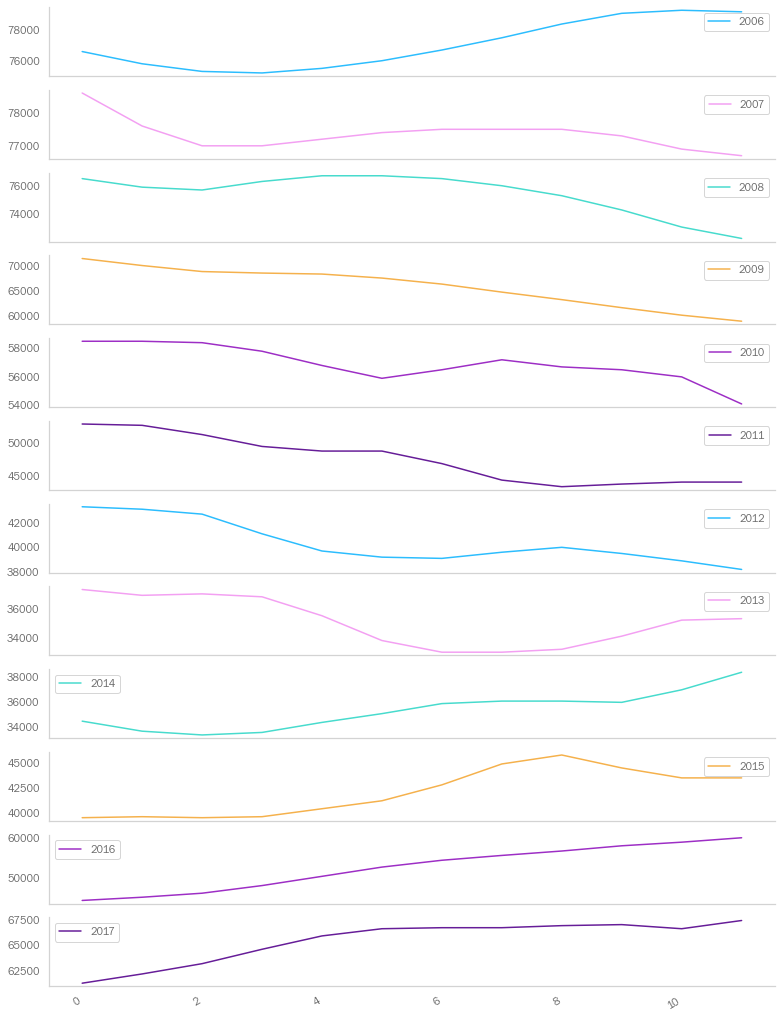

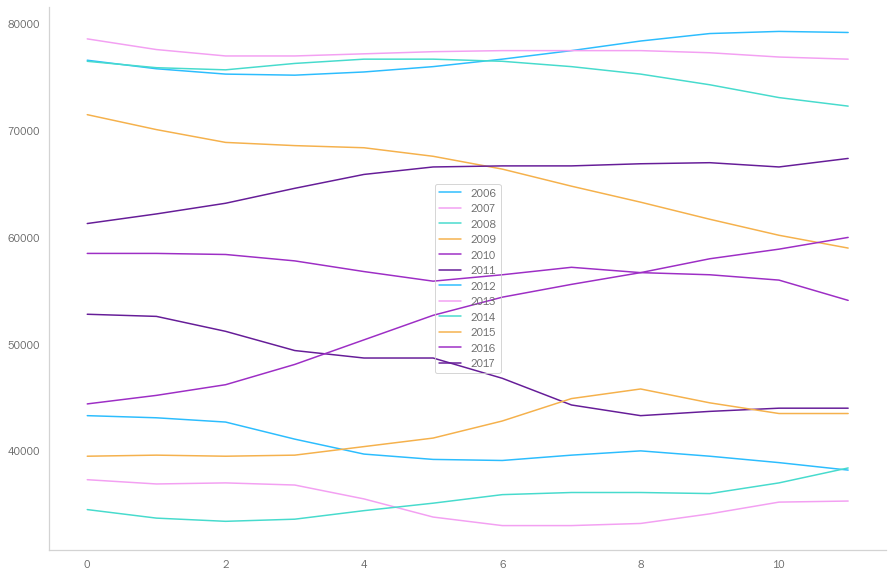

In [60]:
visualize_time_series(Indy_melted, 'Indianapolis') # functioned defined in user_functions.py

# I don't really find the annual breakout graphs to be that helpful for visualization

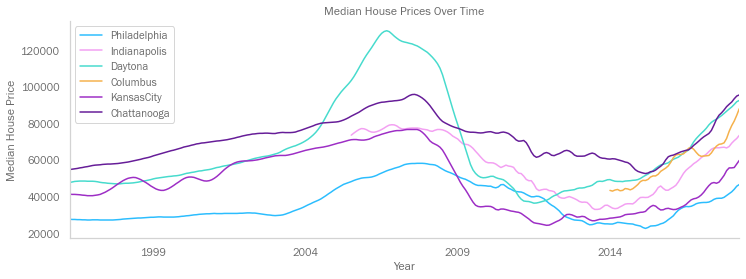

In [61]:
# Plot all 6 chosen zip codes together
all_dfs = [Philly_melted, Indy_melted, Daytona_melted, Columbus_melted, KC_melted, Chattanooga_melted]
names = ['Philadelphia','Indianapolis','Daytona','Columbus','KansasCity','Chattanooga']
visualize_all_series(all_dfs, names) # Function defined in user_functions.py

## Checking for trends, stationarity, seasonality
<pre>
Best Log Transformed Differences (0-5) with p-values

{'Philadelphia': (1, 0.03194585744150177),
 'Indianapolis': (2, 0.7150685269034184),
 'Daytona': (5, 0.15351111071221946),
 'Columbus': (4, 0.018148301922587158),
 'Kansas City': (1, 0.14000751949106677),
 'Chattanooga': (1, 0.14039677392972233)}
 </pre>

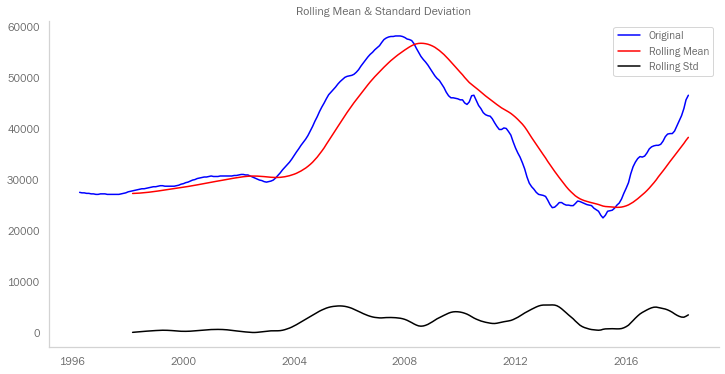

Results of Dickey-Fuller Test: 

Test Statistic                  -0.288166
p-value                          0.927164
#Lags Used                       0.000000
Number of Observations Used    264.000000
Critical Value (1%)             -3.455365
Critical Value (5%)             -2.872551
Critical Value (10%)            -2.572638
dtype: float64


In [62]:
stationarity_check(Philly_melted) # Function defined in user_functions.py
# p-value is greater than .05 (it is .927!) so the series is not stationary

In [63]:
#See what differencing does
data_diff = Philly_melted.diff(periods=1)
data_diff.head(10)

value
time             
1996-04-01    NaN
1996-05-01 -100.0
1996-06-01    0.0
1996-07-01 -100.0
1996-08-01    0.0
1996-09-01 -100.0
1996-10-01    0.0
1996-11-01 -100.0
1996-12-01    0.0
1997-01-01  100.0

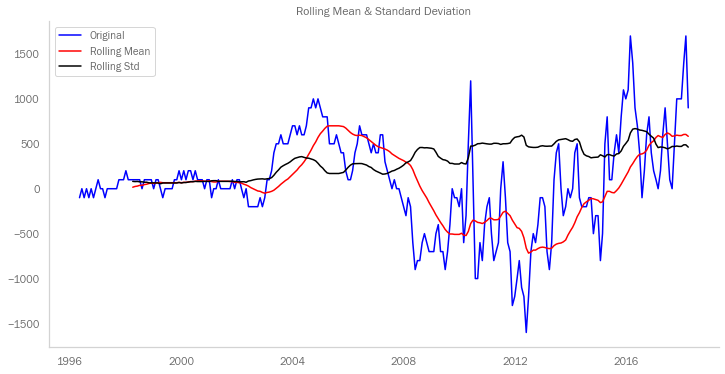

Results of Dickey-Fuller Test: 

Test Statistic                  -2.422182
p-value                          0.135573
#Lags Used                       8.000000
Number of Observations Used    255.000000
Critical Value (1%)             -3.456257
Critical Value (5%)             -2.872942
Critical Value (10%)            -2.572846
dtype: float64


In [64]:
stationarity_check(data_diff[1:])
# p-value is down to .13 but still not stationary

In [65]:
from statsmodels.tsa.stattools import adfuller

def find_best_difference(data):
    for i in range(0,25):
        difference = data.diff(periods=i)
        dftest = adfuller(difference[i:])
        print(i,dftest[1])

find_best_difference(Philly_melted)

0 nan
1 0.1355732285119607
2 0.11919275051848399
3 0.46881217920610363
4 0.06815812325627901
5 0.5883509233410241
6 0.6625687149487411
7 0.6594311981817602
8 0.6800038226664793
9 0.6534124137040307
10 0.4258803417746362
11 0.37733392014565237
12 0.35832937865646863
13 0.5086076402133188
14 0.7541136387628624
15 0.774362568776317
16 0.9158068216563182
17 0.6293119733269782
18 0.7908159564611525
19 0.7702364848871605
20 0.6899295894240023
21 0.5526525850677468
22 0.3944823143309037
23 0.15231458968681078
24 0.25381820081799567


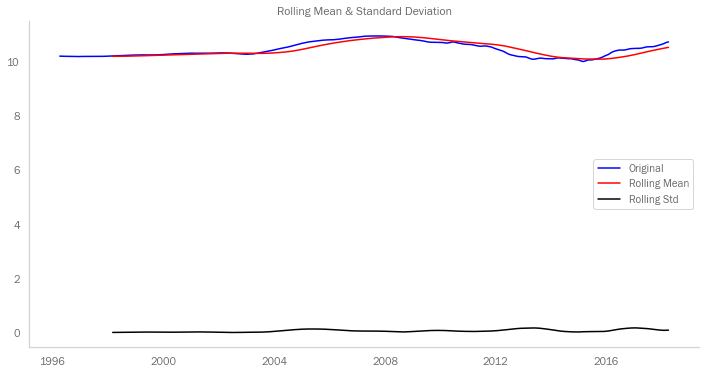

Results of Dickey-Fuller Test: 

Test Statistic                  -2.205328
p-value                          0.204317
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


In [66]:
# Well it doesn't appear that differencing is enough to make this data stationary.  I will try a log transform.

stationarity_check(np.log(Philly_melted))

In [67]:
find_best_difference(np.log(Philly_melted)) # Looks like 1 period difference on the log is enough!

0 nan
1 0.03194585744150177
2 0.05755421697421712
3 0.41215000402719315
4 0.3328238500504311
5 0.5219180086033582
6 0.6242970016812888
7 0.5848581976590658
8 0.6510232059347572
9 0.5855397938521867
10 0.2152804651715723
11 0.31644676563329477
12 0.3180101413235155
13 0.5066454466043491
14 0.7145389957289219
15 0.7496413895092593
16 0.9257344998971225
17 0.5027490612893842
18 0.785076746341453
19 0.4866291610367524
20 0.5239041024548403
21 0.6558632056717053
22 0.3828486937258605
23 0.15615792830432296
24 0.10144107169157374


In [68]:
find_best_difference(Indy_melted) # Similarly, Indy will also not be stationary just with differencing

# I will log transform all data from this point for consistency

0 nan
1 0.6607367844729298
2 0.6710288605269173
3 0.6538440854875729
4 0.8180384416636614
5 0.9168834702182442
6 0.7272629085524935
7 0.972985914001579
8 0.9077547267914667
9 0.9250468892100571
10 0.9475248432116631
11 0.9567961891949055
12 0.8959853887922271
13 0.8727363146890167
14 0.9364298296713139
15 0.9631269272782114
16 0.8440507229682248
17 0.7932262718023664
18 0.6247702692033436
19 0.8627990295543804
20 0.4749649338554318
21 0.4731927953954632
22 0.2701763743725465
23 0.4080676060217747
24 0.4125021871455804


In [69]:
find_best_difference(np.log(Indy_melted))

0 nan
1 0.7169611824126959
2 0.7150685269034184
3 0.7706040494740733
4 0.7316064027092836
5 0.8342752473849291
6 0.7934513927344009
7 0.9239429975367102
8 0.8022629832205488
9 0.8736470080397349
10 0.8879831714495896
11 0.9083559498230531
12 0.8595828254320502
13 0.7216980892314375
14 0.736487471121519
15 0.8862216762430716
16 0.6717269713827985
17 0.26786907914893804
18 0.28044792795807144
19 0.22406085021268823
20 0.1610621757219327
21 0.14248605509675633
22 0.05064913563009264
23 0.09326162148773787
24 0.10517892475263818


In [70]:
# I'm going to get my best difference parameter within 0-5
def find_all_best_log_differences(dfs, names):
    best_scores={}
    for idx, df in enumerate(dfs):
        lowest_score=1 # These are p-values so 1 is the highest
        for i in range(0,6):
            difference = (np.log(df)).diff(periods=i)
            dftest = adfuller(difference[i:])
            if dftest[1] < lowest_score:
                lowest_score = dftest[1]
                best_combo=(i,lowest_score)
        best_scores[names[idx]] = best_combo
    return best_scores    

best_diff = find_all_best_log_differences(all_dfs,names)
best_diff

{'Philadelphia': (1, 0.03194585744150177),
 'Indianapolis': (2, 0.7150685269034184),
 'Daytona': (5, 0.15351111071221946),
 'Columbus': (4, 0.018148301922587158),
 'KansasCity': (1, 0.14000751949106677),
 'Chattanooga': (1, 0.14039677392972233)}

### Seasonal decomposition

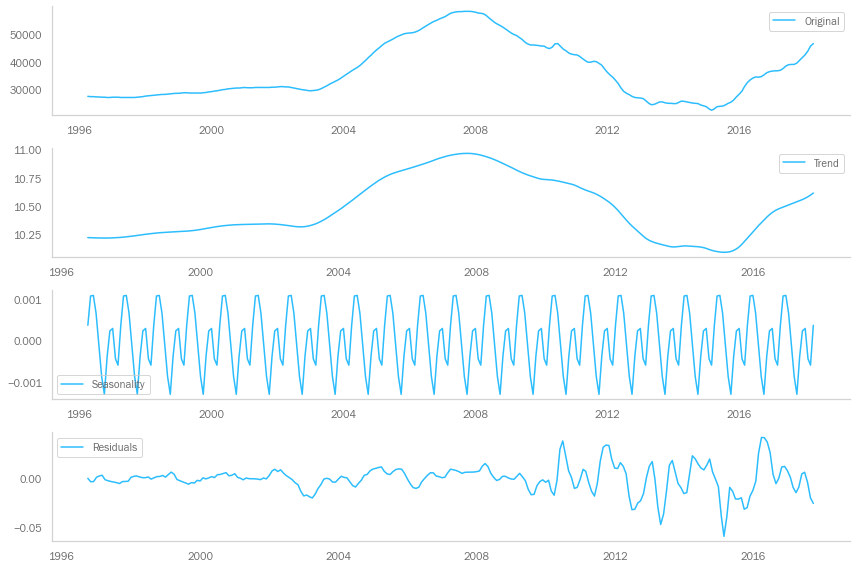

In [71]:
# I will be using logged and difference data in the models but would like to look at how decomposition works for EDA

# Import and apply seasonal_decompose()
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(np.log(Philly_melted))

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(Philly_melted, label='Original')#np.log(ts)
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.savefig('Images/decomposition.png')
plt.tight_layout()

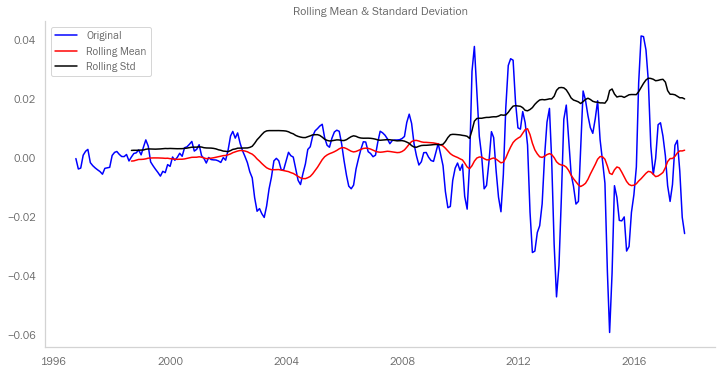

Results of Dickey-Fuller Test: 

Test Statistic                -6.009296e+00
p-value                        1.587583e-07
#Lags Used                     8.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


In [72]:
# Drop missing values from residuals 
Philly_residuals = residual
Philly_residuals.dropna(inplace=True)

# Check stationarity
stationarity_check(Philly_residuals)

# Although the std dev still appears to be trending upward, the p-value indicates stationarity

### Correlation

In [73]:
# To check correlation lets concat all series together
df_group = pd.concat(all_dfs, axis=1)
df_group.columns = names
df_group.corr()

# Highly correlated but they are not stationary at this point

Philadelphia  Indianapolis   Daytona  Columbus  KansasCity  \
Philadelphia      1.000000      0.928714  0.788810  0.937542    0.568138   
Indianapolis      0.928714      1.000000  0.869279  0.933518    0.898426   
Daytona           0.788810      0.869279  1.000000  0.936875    0.829742   
Columbus          0.937542      0.933518  0.936875  1.000000    0.901098   
KansasCity        0.568138      0.898426  0.829742  0.901098    1.000000   
Chattanooga       0.856833      0.928332  0.864986  0.882271    0.777869   

              Chattanooga  
Philadelphia     0.856833  
Indianapolis     0.928332  
Daytona          0.864986  
Columbus         0.882271  
KansasCity       0.777869  
Chattanooga      1.000000

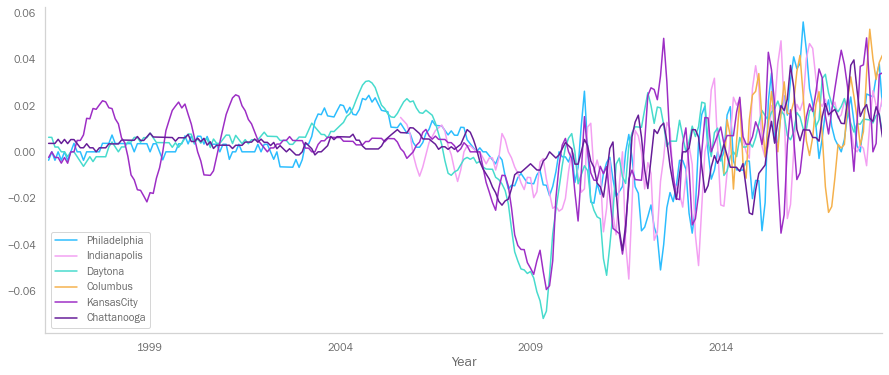

In [74]:
# Let's difference them all then check correlation again
df_group_diff = np.log(df_group).diff(periods=1)
df_group_diff.plot(figsize=(15,6))
plt.xlabel('Year', fontsize=14)
plt.savefig('Images/zips_differenced.png');

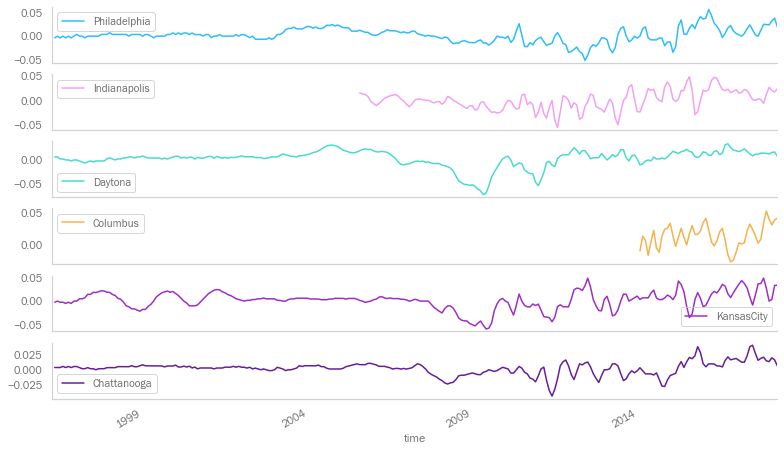

In [75]:
df_group_diff.plot(figsize=(13,8), subplots=True, legend=True)
plt.savefig('Images/differenced_subplots.png');

In [76]:
df_group_diff.corr() # Less correlated when they are differenced 1 period, nothing over .639

Philadelphia  Indianapolis   Daytona  Columbus  KansasCity  \
Philadelphia      1.000000      0.368891  0.378077  0.319255    0.267676   
Indianapolis      0.368891      1.000000  0.388933  0.055788    0.372529   
Daytona           0.378077      0.388933  1.000000 -0.080285    0.639956   
Columbus          0.319255      0.055788 -0.080285  1.000000   -0.048437   
KansasCity        0.267676      0.372529  0.639956 -0.048437    1.000000   
Chattanooga       0.443239      0.250858  0.431938  0.103480    0.393031   

              Chattanooga  
Philadelphia     0.443239  
Indianapolis     0.250858  
Daytona          0.431938  
Columbus         0.103480  
KansasCity       0.393031  
Chattanooga      1.000000

### ACF and PACF

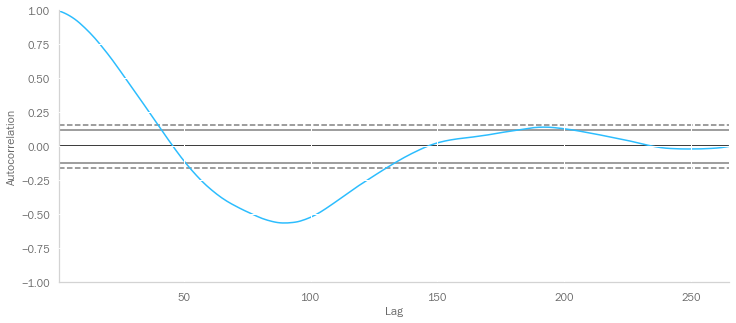

In [77]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(Philly_melted);
# Don't see spikes for yearly correlations

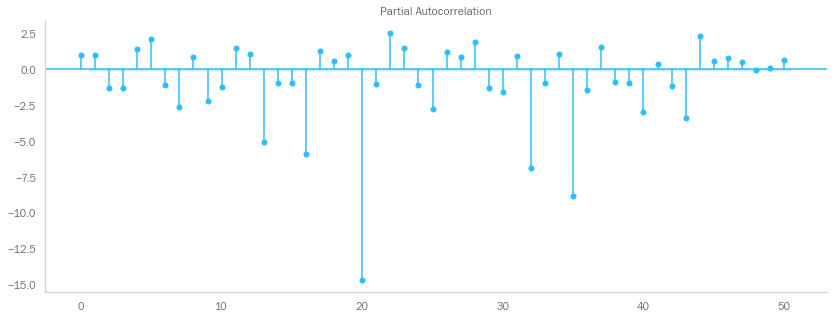

In [78]:
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 5

plot_pacf(Philly_melted, lags=50);

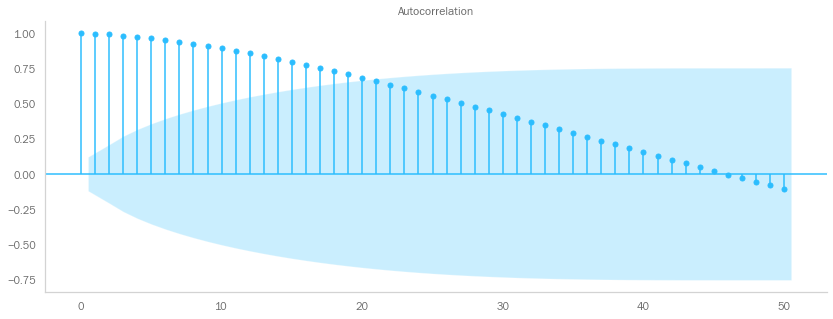

In [79]:
from statsmodels.graphics.tsaplots import plot_acf

rcParams['figure.figsize'] = 14, 5

plot_acf(Philly_melted, lags=50);

## Train Test Split

In [80]:
# My times series have different lengths, some are very short
# I originally split the testing data to be 20% of the data, rather than a particular time period
# However, my training data failed to capture the recent upward trends
# So now I will segment the test/forecasting data to only the most recent year
# Function takes in a list for scalability
# We already created the list and names for a previous function

def test_split(list_of_df, names):
    return_list=[]
    for i, df in enumerate(list_of_df):
#         test_nobs=int((len(df))*.20)
#         training_data = df[:-(test_nobs)]
#         test_data = df[-(test_nobs):]
        training_data = df[:-12]
        test_data = df[-12:]
        return_list.extend([training_data, test_data])
        print(names[i], ': ', df.shape, 'Train: ', training_data.shape, 'Test: ', test_data.shape)
    return return_list

Philly_train, Philly_test, Indy_train, Indy_test, Daytona_train, Daytona_test, \
    Columbus_train, Columbus_test, KC_train, KC_test, Chattanooga_train, Chattanooga_test = test_split(all_dfs, names)


Philadelphia :  (265, 1) Train:  (253, 1) Test:  (12, 1)
Indianapolis :  (154, 1) Train:  (142, 1) Test:  (12, 1)
Daytona :  (265, 1) Train:  (253, 1) Test:  (12, 1)
Columbus :  (52, 1) Train:  (40, 1) Test:  (12, 1)
KansasCity :  (265, 1) Train:  (253, 1) Test:  (12, 1)
Chattanooga :  (265, 1) Train:  (253, 1) Test:  (12, 1)


In [81]:
Columbus_test

value
time               
2017-05-01  63900.0
2017-06-01  66000.0
2017-07-01  67600.0
2017-08-01  68600.0
2017-09-01  68800.0
2017-10-01  69400.0
2017-11-01  71800.0
2017-12-01  75700.0
2018-01-01  78800.0
2018-02-01  81300.0
2018-03-01  84500.0
2018-04-01  88100.0

In [82]:
# Making lists to run through models together
all_train_df = [Philly_train, Indy_train, Daytona_train, Columbus_train, KC_train, Chattanooga_train]
all_test_df = [Philly_test, Indy_test, Daytona_test, Columbus_test, KC_test, Chattanooga_test]

## Baseline ARIMA modeling

<pre>

    Name             Order     Seasonal_Order  Fit_Time   Const      ar.L1   ma.L1   sigma2     AIC Score
0   Philadelphia    (1, 0, 1)   (0, 0, 0, 0)    0.1751   36279.03   0.9975  0.7643  105736.54   3660.12
1   Indianapolis    (1, 0, 1)   (0, 0, 0, 0)    0.1616   56143.06   0.9971  0.8044  365498.65   2237.24
2   Daytona         (1, 0, 1)   (0, 0, 0, 0)    0.1536   65794.06   0.9976  0.9413  541074.22   4074.94
3   Columbus        (1, 0, 1)   (0, 0, 0, 0)    0.0608   54074.93   0.9913  0.9994  362743.00    642.68
4   Kansas City     (1, 0, 1)   (0, 0, 0, 0)    0.1556   48263.62   0.9970  0.8875  209724.01   3834.07
5   Chattanooga     (1, 0, 1)   (0, 0, 0, 0)    0.2144   70698.40   0.9979  0.8266  167378.79   3776.88
</pre>

In [84]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

# Establish a metrics dataframe to store models
column_metrics = ['Name', 'Order', 'Seasonal_Order', 'Fit_Time', 
                  'Const', 'ar.L1', 'ma.L1', 'sigma2', 'AIC Score']
metrics_df = pd.DataFrame(columns = column_metrics)

# Start with a baseline model of AR(1) and MA(1)
order=(1,0,1)

for i, train_df in enumerate(all_train_df):
    metrics_df = run_arima_models(names[i], train_df, all_test_df[i], order, metrics_df) # Function in user_functions.py

metrics_df

Name      Order Seasonal_Order  Fit_Time     Const   ar.L1   ma.L1  \
0  Philadelphia  (1, 0, 1)   (0, 0, 0, 0)    0.1396  36279.03  0.9975  0.7643   
1  Indianapolis  (1, 0, 1)   (0, 0, 0, 0)    0.1297  56143.06  0.9971  0.8044   
2       Daytona  (1, 0, 1)   (0, 0, 0, 0)    0.1366  65794.06  0.9976  0.9413   
3      Columbus  (1, 0, 1)   (0, 0, 0, 0)    0.0648  54074.93  0.9913  0.9994   
4    KansasCity  (1, 0, 1)   (0, 0, 0, 0)    0.1297  48263.62  0.9970  0.8875   
5   Chattanooga  (1, 0, 1)   (0, 0, 0, 0)    0.1875  70698.40  0.9979  0.8266   

      sigma2  AIC Score  
0  105736.54    3660.12  
1  365498.65    2237.24  
2  541074.22    4074.94  
3  362743.00     642.68  
4  209724.01    3834.07  
5  167378.79    3776.88

## Find Optimal p,d,q

### Philly

<pre>
pdq         (2, 1, 2)
pdqs    (1, 0, 1, 12)
aic          -1818.25
Name: 226, dtype: object
</pre>

In [85]:
# Putting in the best d value calculated earlier saves a lot of time in the grid search, though potentially gives 
# different values

tic = time.time()
Philly_grid_search = grid_search_arima(np.log(Philly_train), 
                                       d = best_diff['Philadelphia'][0]) # Function in user_functions.py
print(time.time()-tic)

pdq         (2, 1, 2)
pdqs    (1, 0, 1, 12)
aic          -1818.25
Name: 226, dtype: object
366.6337876319885


In [86]:
'''There is no problem with a positive log-likelihood. It is a common misconception that the log-likelihood must be 
negative.  If the likelihood is derived from a probability density it can quite reasonably exceed 1 which means that
log-likelihood is positive, hence the deviance and the AIC are negative. This is what occurred in your model.

If you believe that comparing AICs is a good way to choose a model then it would still be the case that the (algebraically)
lower AIC is preferred not the one with the lowest absolute AIC value. To reiterate you want the most negative number in
your example.'''

'There is no problem with a positive log-likelihood. It is a common misconception that the log-likelihood must be \nnegative.  If the likelihood is derived from a probability density it can quite reasonably exceed 1 which means that\nlog-likelihood is positive, hence the deviance and the AIC are negative. This is what occurred in your model.\n\nIf you believe that comparing AICs is a good way to choose a model then it would still be the case that the (algebraically)\nlower AIC is preferred not the one with the lowest absolute AIC value. To reiterate you want the most negative number in\nyour example.'

In [87]:
Philly_model = ARIMA(np.log(Philly_train), order=(2,1,2), seasonal_order=(1,0,1,12), freq='MS')
Philly_results = Philly_model.fit()
print(Philly_results.aic)

-1818.2534500111883


In [88]:
# Because so many values came up as '2' in my grid search, I would like to expand my grid to higher values.
tic = time.time()
p = d = q = range(2, 5)
pdq = list(itertools.product(p, d, q))
pdqs = [(1,0,1,12)]
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            grid_model = ARIMA(np.log(Philly_train), order=comb, seasonal_order=combs, freq='MS')
            grid_results = grid_model.fit()
            ans.append([comb, combs, grid_results.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, results.aic))
        except:
            continue
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
print(ans_df.loc[ans_df['aic'].idxmin()])
print(time.time()-tic)

pdq         (2, 2, 3)
pdqs    (1, 0, 1, 12)
aic          -1822.04
Name: 1, dtype: object
21.523201942443848


In [89]:
# So with (2,1,2) aic was -1818. With (2,2,3) aic is -1822. I'm not sure that is enough difference to justify the
# addition of the extra parameters

In [90]:
Philly_metrics = track_final_metrics(Philly_grid_search, Philly_results, names[0]) # function in user_functions.py

### Indy

<pre>
pdq         (1, 2, 2)
pdqs    (2, 0, 2, 12)
aic          -867.448
Name: 155, dtype: object
</pre>

In [91]:
tic = time.time()
Indy_grid_search = grid_search_arima(np.log(Indy_train), d = best_diff['Indianapolis'][0])
print(time.time()-tic)

pdq         (1, 2, 2)
pdqs    (2, 0, 2, 12)
aic          -867.448
Name: 155, dtype: object
309.1987555027008


In [92]:
Indy_model = ARIMA(np.log(Indy_train), order=(1,2,2), seasonal_order=(2,0,2,12), freq='MS')
Indy_results = Indy_model.fit()
print(Indy_results.aic)

-867.4478406929932


In [93]:
Indy_metrics = track_final_metrics(Indy_grid_search, Indy_results, names[1]) # function in user_functions.py

### Daytona

<pre>
pdq         (0, 5, 2)
pdqs    (0, 0, 0, 12)
aic          -1824.65
Name: 54, dtype: object
</pre>

In [94]:
tic = time.time()
Daytona_grid_search = grid_search_arima(np.log(Daytona_train), d = best_diff['Daytona'][0])
print(time.time()-tic)

pdq         (0, 5, 2)
pdqs    (0, 0, 0, 12)
aic          -1824.65
Name: 54, dtype: object
596.0486102104187


In [95]:
Daytona_grid_search

pdq           pdqs          aic
0    (0, 5, 0)  (0, 0, 0, 12) -1414.539641
1    (0, 5, 0)  (0, 0, 1, 12) -1417.087372
2    (0, 5, 0)  (0, 0, 2, 12) -1413.983055
3    (0, 5, 0)  (0, 1, 0, 12) -1151.848313
4    (0, 5, 0)  (0, 1, 1, 12) -1288.018780
..         ...            ...          ...
238  (2, 5, 2)  (2, 1, 1, 12) -1459.375987
239  (2, 5, 2)  (2, 1, 2, 12) -1504.250667
240  (2, 5, 2)  (2, 2, 0, 12) -1249.043222
241  (2, 5, 2)  (2, 2, 1, 12) -1243.620754
242  (2, 5, 2)  (2, 2, 2, 12) -1288.388315

[243 rows x 3 columns]

In [96]:
Daytona_model = ARIMA(np.log(Daytona_train), order=(0,5,2), seasonal_order=(0,0,0,12), freq='MS')
Daytona_results = Daytona_model.fit()
print(Daytona_results.aic)

-1824.6532776198896


In [97]:
Daytona_metrics = track_final_metrics(Daytona_grid_search, Daytona_results, names[2]) # function in user_functions.py

### Columbus

<pre>
pdq         (2, 4, 1)
pdqs    (1, 0, 0, 12)
aic          -194.596
Name: 198, dtype: object
</pre>

In [98]:
tic = time.time()
Columbus_grid_search = grid_search_arima(np.log(Columbus_train), d = best_diff['Columbus'][0])
print(time.time()-tic)

pdq         (2, 4, 1)
pdqs    (1, 0, 0, 12)
aic          -194.596
Name: 198, dtype: object
170.1638731956482


In [99]:
Columbus_model = ARIMA(np.log(Columbus_train), order=(2,4,1), seasonal_order=(1,0,0,12), freq='MS')
Columbus_results = Columbus_model.fit()
print(Columbus_results.aic)

-194.5958648817607


In [100]:
Columbus_metrics = track_final_metrics(Columbus_grid_search, Columbus_results, names[3]) # function in user_functions.py

### Kansas City

<pre>
pdq         (1, 1, 2)
pdqs    (0, 0, 2, 12)
aic          -1801.54
Name: 137, dtype: object
</pre>

In [101]:
tic = time.time()
KC_grid_search = grid_search_arima(np.log(KC_train), d = best_diff['KansasCity'][0])
print(time.time()-tic)

pdq         (1, 1, 2)
pdqs    (0, 0, 2, 12)
aic          -1801.54
Name: 137, dtype: object
382.5188422203064


In [102]:
KC_model = ARIMA(np.log(KC_train), order=(1,1,2), seasonal_order=(0,0,2,12), freq='MS')
KC_results = KC_model.fit()
print(KC_results.aic)

-1801.535745337077


In [103]:
KC_metrics = track_final_metrics(KC_grid_search, KC_results, names[4]) # function in user_functions.py

### Chattanooga

<pre>
pdq         (1, 1, 2)
pdqs    (0, 0, 2, 12)
aic          -2068.06
Name: 137, dtype: object
</pre>

In [104]:
tic = time.time()
Chattanooga_grid_search = grid_search_arima(np.log(Chattanooga_train), d = best_diff['Chattanooga'][0])
print(time.time()-tic)

pdq         (1, 1, 2)
pdqs    (0, 0, 2, 12)
aic          -2068.06
Name: 137, dtype: object
373.5620331764221


In [105]:
Chattanooga_model = ARIMA(np.log(Chattanooga_train), order=(1,1,2), seasonal_order=(0,0,2,12), freq='MS')
Chattanooga_results = Chattanooga_model.fit()
print(Chattanooga_results.aic)

-2068.064330716703


In [106]:
Chattanooga_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                            value   No. Observations:                  253
Model:             ARIMA(1, 1, 2)x(0, 0, 2, 12)   Log Likelihood                1040.032
Date:                          Sun, 31 Jan 2021   AIC                          -2068.064
Time:                                  18:18:17   BIC                          -2046.888
Sample:                              04-01-1996   HQIC                         -2059.543
                                   - 04-01-2017                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7161      0.039     18.303      0.000       0.639       0.793
ma.L1          0.7526      0.049     15.384      0.000       0.657       0.848
ma.L2          0.2969      0.044      6.726      0.000       0.210       0.383
ma.S.L12      -0.1871      0.064     -2.938      0.003      -0.312      -0.062
ma.S.L24      -0.1307      0.057     -2.282      0.022      -0.243      -0.018
sigma2      1.501e-05   9.31e-07     16.111      0.000    1.32e-05    1.68e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):               172.83
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               8.97   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [107]:
Chattanooga_metrics = track_final_metrics(Chattanooga_grid_search, Chattanooga_results, names[5])

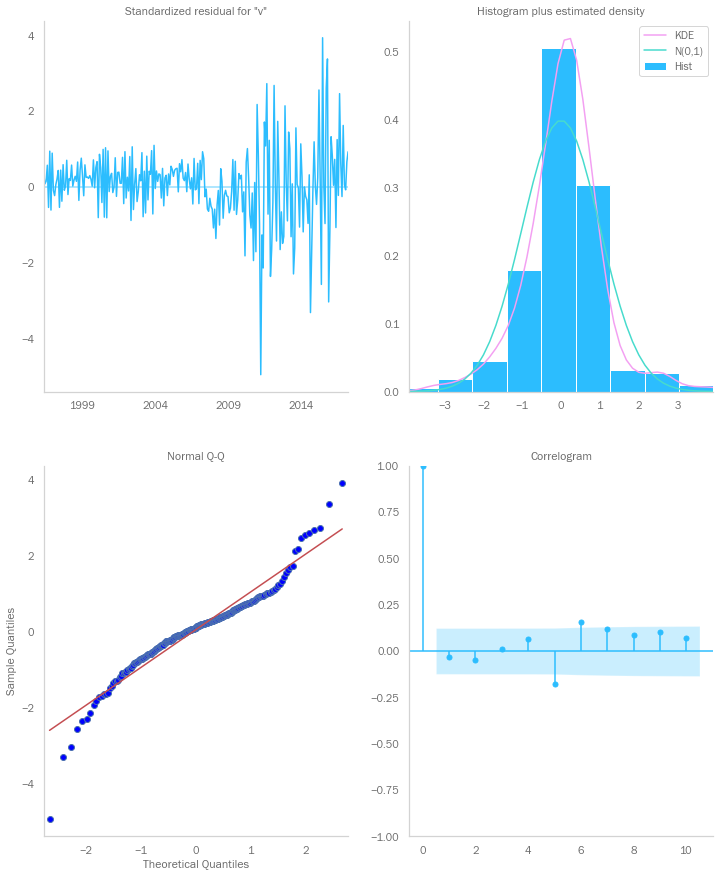

In [108]:
Chattanooga_results.plot_diagnostics(figsize=(12, 15))
plt.savefig('Images/Chat_diagnostics.png')

## Visualize predictions and Calculate RMSE for top models

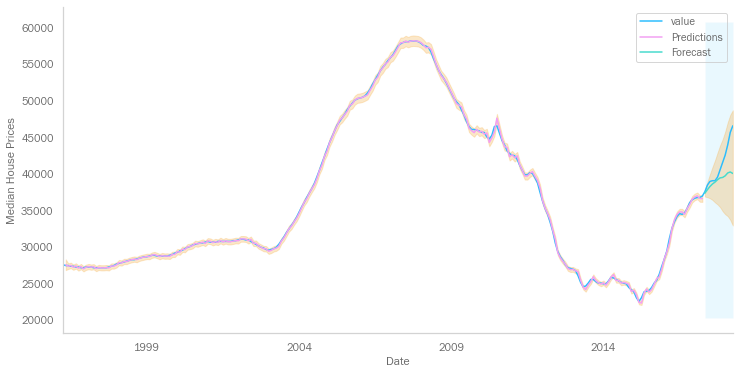

The Root Mean Squared Error of Philadelphia predictions is 210.12
The Root Mean Squared Error of Philadelphia forecasts is 2904.6


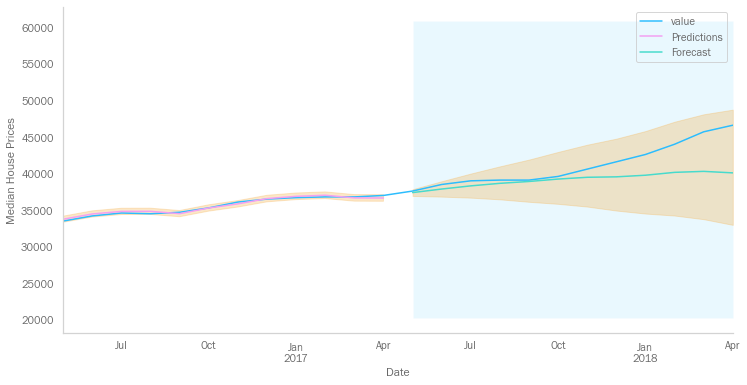

In [109]:
Philly_pred, Philly_forecast, Philly_train_rmse, Philly_test_rmse = \
    run_preds_and_plot(Philly_results, Philly_train, Philly_test, 'Philadelphia', best_diff)
Philly_metrics.update({'train rmse': Philly_train_rmse, 'test rmse': Philly_test_rmse})

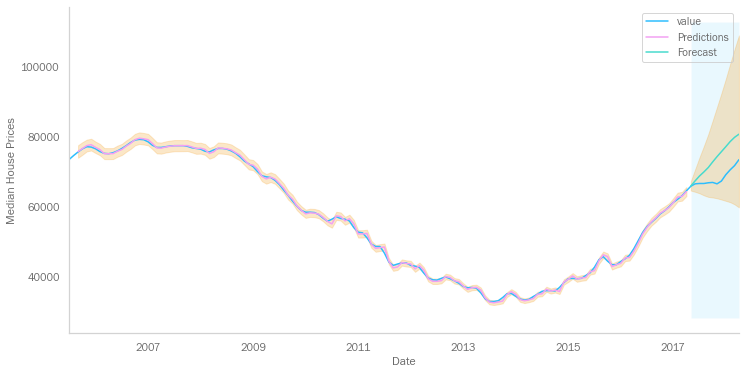

The Root Mean Squared Error of Indianapolis predictions is 473.98
The Root Mean Squared Error of Indianapolis forecasts is 6108.44


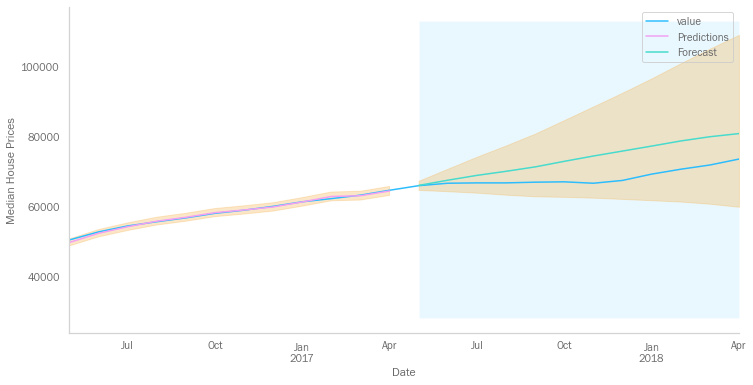

In [110]:
Indy_pred, Indy_forecast, Indy_train_rmse, Indy_test_rmse = run_preds_and_plot(Indy_results, 
                                                                               Indy_train, Indy_test, 'Indianapolis',
                                                                              best_diff)
Indy_metrics.update({'train rmse': Indy_train_rmse, 'test rmse': Indy_test_rmse})

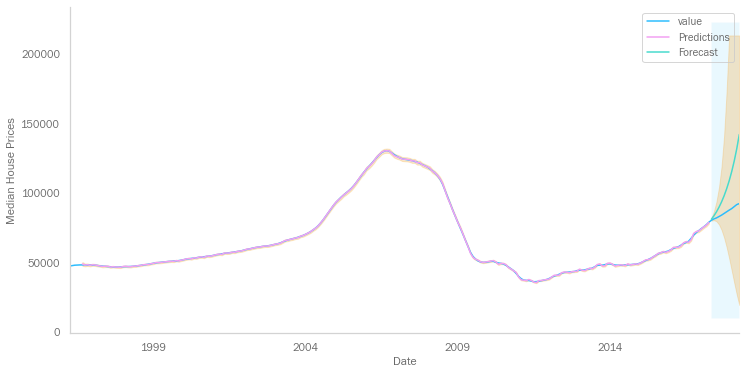

The Root Mean Squared Error of Daytona predictions is 318.07
The Root Mean Squared Error of Daytona forecasts is 23990.07


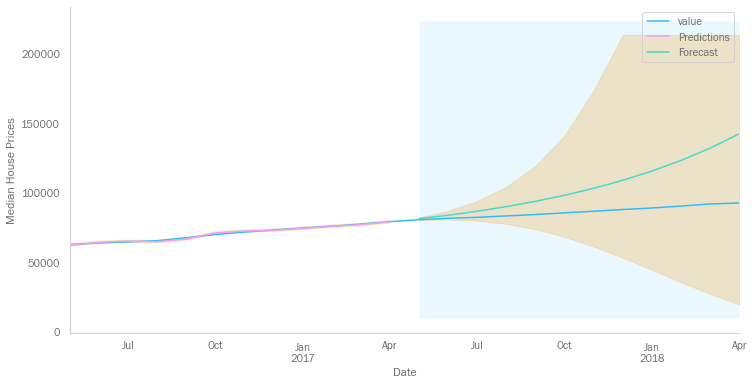

In [111]:
Daytona_pred, Daytona_forecast, Daytona_train_rmse, Daytona_test_rmse = \
    run_preds_and_plot(Daytona_results, Daytona_train, Daytona_test, 'Daytona', best_diff)
Daytona_metrics.update({'train rmse': Daytona_train_rmse, 'test rmse': Daytona_test_rmse})

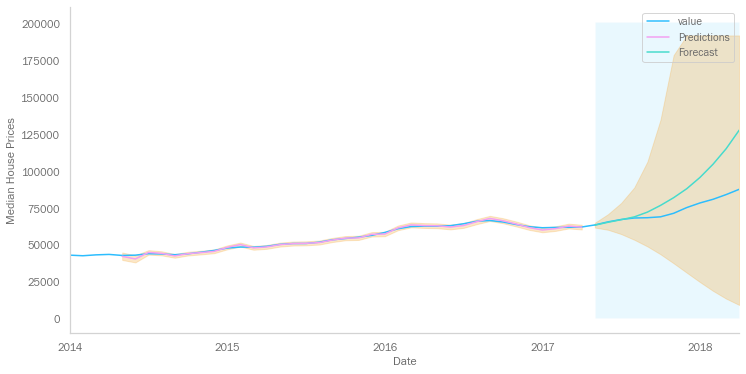

The Root Mean Squared Error of Columbus predictions is 844.18
The Root Mean Squared Error of Columbus forecasts is 17797.27


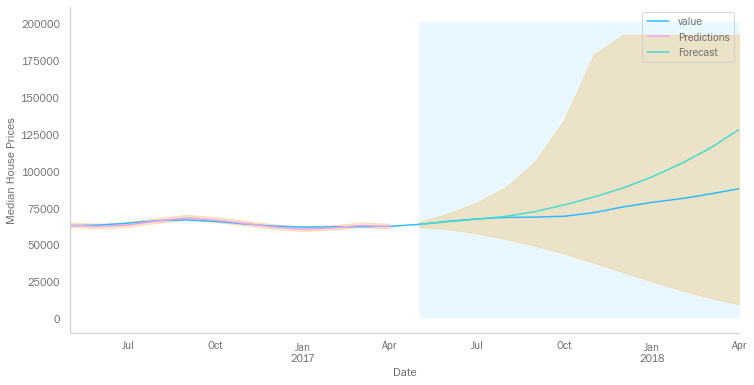

In [112]:
Columbus_pred, Columbus_forecast, Columbus_train_rmse, Columbus_test_rmse = \
    run_preds_and_plot(Columbus_results, Columbus_train, Columbus_test, 'Columbus', best_diff)
Columbus_metrics.update({'train rmse': Columbus_train_rmse, 'test rmse': Columbus_test_rmse})

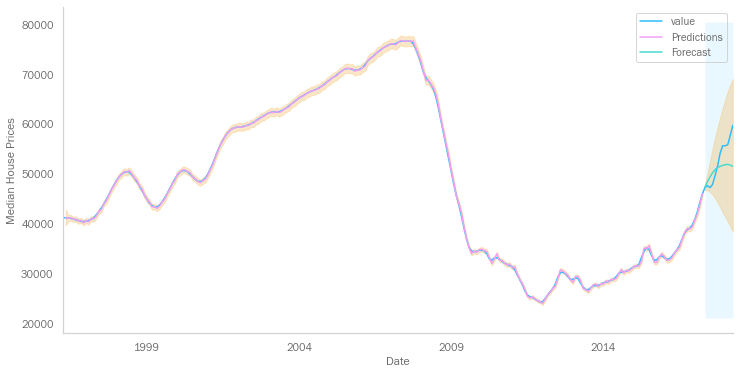

The Root Mean Squared Error of KansasCity predictions is 243.3
The Root Mean Squared Error of KansasCity forecasts is 3745.08


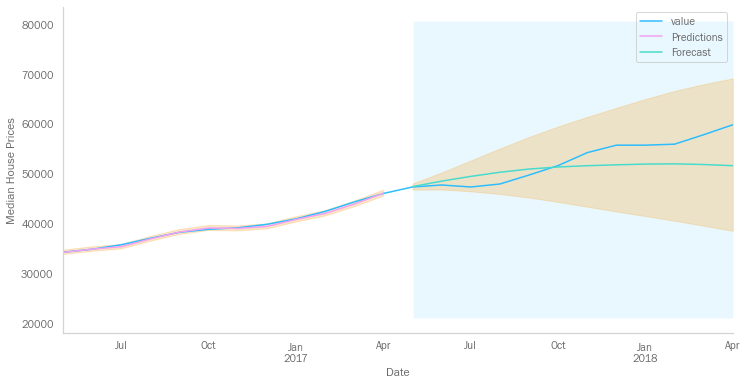

In [113]:
KC_pred, KC_forecast, KC_train_rmse, KC_test_rmse = run_preds_and_plot(KC_results, KC_train, KC_test, 'KansasCity',
                                                                      best_diff)
KC_metrics.update({'train rmse': KC_train_rmse, 'test rmse': KC_test_rmse})

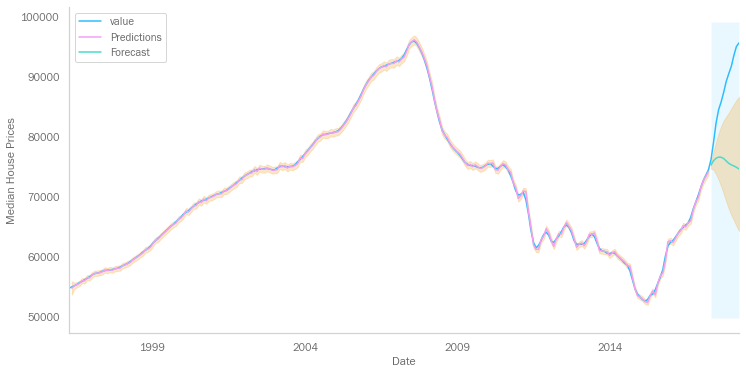

The Root Mean Squared Error of Chattanooga predictions is 254.97
The Root Mean Squared Error of Chattanooga forecasts is 13426.12


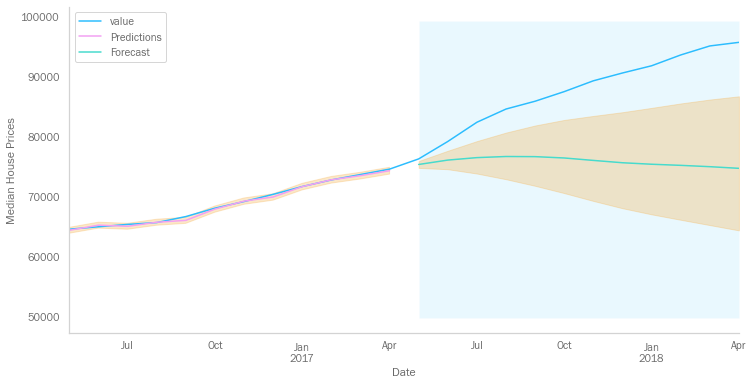

In [114]:
Chattanooga_pred, Chattanooga_forecast, Chattanooga_train_rmse, Chattanooga_test_rmse = \
    run_preds_and_plot(Chattanooga_results, Chattanooga_train, Chattanooga_test, 'Chattanooga', best_diff)
Chattanooga_metrics.update({'train rmse': Chattanooga_train_rmse, 'test rmse': Chattanooga_test_rmse})

## Facebook Prophet

In [115]:
from fbprophet import Prophet

In [116]:
Philly_proph = Philly_train.reset_index()
Philly_proph.columns = ['ds', 'y']
Philly_proph

ds        y
0   1996-04-01  27600.0
1   1996-05-01  27500.0
2   1996-06-01  27500.0
3   1996-07-01  27400.0
4   1996-08-01  27400.0
..         ...      ...
248 2016-12-01  36500.0
249 2017-01-01  36700.0
250 2017-02-01  36800.0
251 2017-03-01  36800.0
252 2017-04-01  37000.0

[253 rows x 2 columns]

In [117]:
prophet_model = Prophet()
prophet_model.fit(Philly_proph)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [118]:
future = prophet_model.make_future_dataframe(freq ='MS', periods=12)
future.tail()

ds
260 2017-12-01
261 2018-01-01
262 2018-02-01
263 2018-03-01
264 2018-04-01

In [119]:
forecast = prophet_model.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

ds          yhat    yhat_lower    yhat_upper
260 2017-12-01  31263.594936  28343.943331  34389.437167
261 2018-01-01  31343.365536  28419.795132  34293.161551
262 2018-02-01  31325.741272  28325.238875  34484.651475
263 2018-03-01  31495.508175  28673.347796  34593.682411
264 2018-04-01  31553.705527  28587.227066  34844.157742

In [143]:
prophet_ROI = ((forecast.yhat.iloc[-1]) - (forecast.yhat.iloc[-12]))/(forecast.yhat.iloc[-12])
prophet_ROI # ARIMA model forecast 7%, actual value was 25%

0.030605143650945077

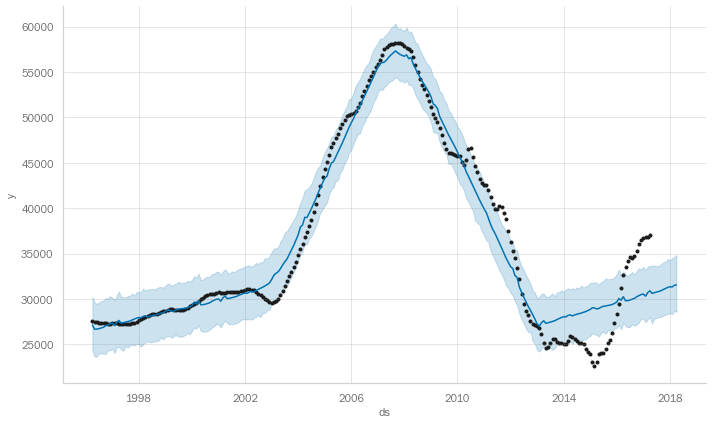

In [120]:
fig1 = prophet_model.plot(forecast)

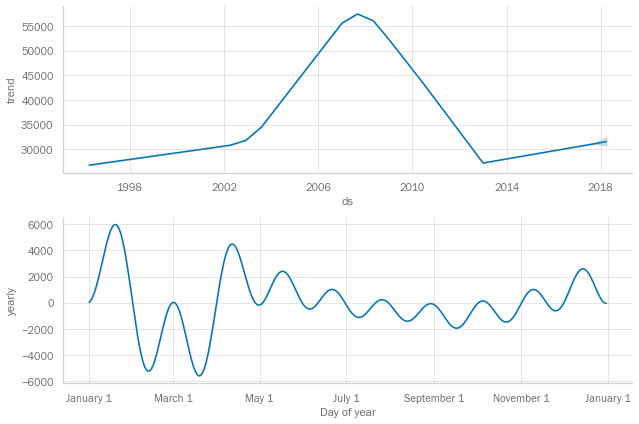

In [121]:
fig2 = prophet_model.plot_components(forecast)

In [122]:
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(prophet_model, forecast)

In [123]:
plot_components_plotly(prophet_model, forecast)

## Interpret Results / Conclusions

In [124]:
pd.DataFrame([Philly_metrics, Indy_metrics, Daytona_metrics, Columbus_metrics, KC_metrics, Chattanooga_metrics])

name      order seasonal order   ar.L1   ar.L2   ma.L1   ma.L2  \
0  Philadelphia  (2, 1, 2)  (1, 0, 1, 12)  1.1489 -0.1829 -0.1092 -0.3715   
1  Indianapolis  (1, 2, 2)  (2, 0, 2, 12)  0.4495     NaN -0.2736 -0.5485   
2       Daytona  (0, 5, 2)  (0, 0, 0, 12)     NaN     NaN -1.9436  0.9541   
3      Columbus  (2, 4, 1)  (1, 0, 0, 12) -0.0722 -0.8108 -0.9405     NaN   
4    KansasCity  (1, 1, 2)  (0, 0, 2, 12)  0.7820     NaN  0.7766  0.2137   
5   Chattanooga  (1, 1, 2)  (0, 0, 2, 12)  0.7161     NaN  0.7526  0.2969   

   ar.S.L12  ma.S.L12  sigma2      aic  train rmse     test rmse  ar.S.L24  \
0    0.5673   -0.9261  0.0000 -1818.25  210.120410   2904.602710       NaN   
1   -0.2887    0.2439  0.0001  -867.45  473.983586   6108.436530     0.367   
2       NaN       NaN  0.0000 -1824.65  318.066481  23990.065072       NaN   
3   -0.2056       NaN  0.0002  -194.60  844.184953  17797.268489       NaN   
4       NaN   -0.1090  0.0000 -1801.54  243.298505   3745.083869       NaN   
5       NaN   -0.1871  0.0000 -2068.06  254.974561  13426.120075       NaN   

   ma.S.L24  
0       NaN  
1   -0.6304  
2       NaN  
3       NaN  
4   -0.1074  
5   -0.1307

In [125]:
original_dfs = [Philly, Indy, Daytona, Columbus, KC, Chattanooga]
forecast_dfs = [Philly_forecast, Indy_forecast, Daytona_forecast, Columbus_forecast, KC_forecast, Chattanooga_forecast]
for df in original_dfs:
    df.reset_index(drop=True, inplace=True)

In [126]:
def calc_forecast_ROI(forecast):
    return ((np.exp(forecast.predicted_mean)[-1] - np.exp(forecast.predicted_mean)[-12])/
            np.exp(forecast.predicted_mean)[-12])

In [127]:
def final_ROI(dfs, forecasts):
    comparison = pd.DataFrame(index=['Zip Code','median housing price','actual 2018 ROI', 'forecast 2018 ROI'])
    for i, df in enumerate(dfs):
        metrics = [df['RegionName'][0], df.iloc[0,-1], round(100*df['recent_1_yr_ROI'][0],2), 
                   round(100*calc_forecast_ROI(forecasts[i]),2)]
        comparison[df['City'][0]] = metrics        
    return comparison

ROI_comparison = final_ROI(original_dfs, forecast_dfs)
ROI_comparison

Philadelphia Indianapolis Daytona Beach Columbus  \
Zip Code                    19134        46203         32114    43206   
median housing price        46600        73500         92600    88100   
actual 2018 ROI             25.95        13.78         16.92    40.96   
forecast 2018 ROI            7.21        22.42         75.04   101.29   

                     Kansas City Chattanooga  
Zip Code                   66104       37411  
median housing price       59800       95600  
actual 2018 ROI               30       28.32  
forecast 2018 ROI           8.87       -0.85

Results: 

* All training data outperformed the test data.
* The models are all very skewed because of the market crash in 2009.
* Columbus and Daytona had very large confidence intervals and overly high forecasts.
* Chattanooga has outperformed even the confidence intervals of the model.
* Philadelphia is potentially a good 50K investment , Indianapolis at 75K and Chattanooga at 100K investment

Caveats: 
* Logged and differenced the data but some still did not test as stationary according to the Dickey Fuller test.
* Real estate predictions can vary due to unseen fluctuations in the market

Next Steps/Future Work: 
* Obtain current data after 2018 for current predictions. Found zip data on Redfin but it is rolling avg by zip code.
* Investigate why some of the models seem so far off in their forecasts.
